In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from astropy import constants as const
from matplotlib import ticker, cm
from matplotlib import colors
from astropy import units as u
import scipy 
from astropy.io import fits
import pandas
import corner
from astropy.table import Table, vstack
kwarg1d = {'histtype':'stepfilled','color':'orange'}

In [2]:
def norm_transform(norm):
    distance = 7.5*u.kpc
    nenHdV = 1e14*4*np.pi * distance.to(u.cm)**2*norm
    return nenHdV.value

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def time_curves(norm_region,volume_region, age, k):
    return np.sqrt(norm_region/(1.2*volume_region))*age.to(u.s) *k # k is a constant representing difference between tau and tau0 from Fig.4 of Borkowski et al (2001)

def snr_volume(physical_size):
    return (4/3*np.pi*physical_size.to(u.cm)**3) /4 # (the last 4 is due to the filling factor of 25%)

cmap = cm.get_cmap('RdGy')
cmap = truncate_colormap(cmap, 0., 0.45)
cmap.set_bad(color='white')

ticks_values = np.arange(0,55,5)
tick_labels = ['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '>50']

params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'figure.dpi': 150,
          'font.size': 10,
          'axes.linewidth': 1.5
         }

# Volume calculations

In [3]:
def snr_volume(physical_size):
    return (4/3*np.pi*physical_size.to(u.cm)**3) /4 # (the last 4 is due to the filling factor of 25%)

def snr_density(norm_region,volume_region):
    return np.sqrt(norm_region/(1.2*volume_region))

def age(tau_region, snr_density_region):
    return ((tau_region/snr_density_region) / u.cm).to(u.yr)

def time_curves(norm_region,volume_region, age):
    return np.sqrt(norm_region/(1.2*volume_region))*age.to(u.s)

def time_curves_k(norm_region,volume_region, age, k):
    return np.sqrt(norm_region/(1.2*volume_region))*age.to(u.s) *k # k is a constant representing difference between tau and tau0 from Fig.4 of Borkowski et al (2001)


In [4]:
kT_region1=0.970177 * u.keV # err -0.0620728,0.0907647
tau_region1=4.24009E+10 * (u.s * (u.cm)**-2)
norm_region1=5.49037E-03

kT_region2=1.86771 * u.keV # err -0.367943,0.552363
tau_region2=1.65810E+10 * (u.s * (u.cm)**-2) 
norm_region2=7.09164E-04

In [5]:
angular_size = 3.5 * u.arcmin
distance = 7.5 * u.kpc
physical_size = np.sin(angular_size)*distance
print('physical size =',physical_size.to(u.pc))
volume_total = snr_volume(physical_size)
volume_region1 = 0.30*volume_total
volume_region2 = 0.25*volume_total
print('Angular size =',angular_size)
print('Distance =',distance)
print('--------------')
print("Region 1 V = {:.2e}".format(volume_region1))
print('Region 2 V = {:.2e}'.format(volume_region2))

physical size = 7.635814158330376 pc
Angular size = 3.5 arcmin
Distance = 7.5 kpc
--------------
Region 1 V = 4.11e+57 cm3
Region 2 V = 3.42e+57 cm3


## Density and age (from Tau)

In [6]:
k = 0.3 
nHnedV_region1= norm_transform(norm_region1) * (u.cm)**-3
snr_density_region1 = snr_density(nHnedV_region1,volume_region1)
bestfit_age_region1 = (( (tau_region1/k) /snr_density_region1) / u.cm).to(u.yr)

nHnedV_region2= norm_transform(norm_region2)* (u.cm)**-3
snr_density_region2 = snr_density(nHnedV_region2,volume_region2)
bestfit_age_region2 = (( (tau_region2/k) /snr_density_region2) / u.cm).to(u.yr)


print('Region 1 n_H ={:.3f}'.format(snr_density_region1))
print('Region 2 n_H ={:.3f}'.format(snr_density_region2))
print('--------------')
print('Region 1 age = {:.2f}'.format(bestfit_age_region1))
print('Region 2 age = {:.2f}'.format(bestfit_age_region2))

Region 1 n_H =0.866 1 / cm3
Region 2 n_H =0.341 1 / cm3
--------------
Region 1 age = 5173.77 yr
Region 2 age = 5139.01 yr


## Explosion energy

In [7]:
radius = physical_size.to(u.cm)
particle_density = 0.49*(u.cm)**(-3)
age = ((1550*u.yr).to(u.s))
E = 1e51 * u.erg

In [8]:
def explosion_energy(radius, particle_density,age):
    return ((1.4*0.25*particle_density*const.m_p*(radius**5))/(2.026*age.to(u.s)**2))

explosion_energy(radius, particle_density,age).to(u.erg)

<Quantity 4.29715092e+50 erg>

In [9]:
def explosion_time(radius, particle_density,E):
    return np.sqrt((1.4*0.25*particle_density*const.m_p*(radius**5))/(2.026*E))

particle_density_1 = 0.87*(u.cm)**(-3)
particle_density_2 = 0.34*(u.cm)**(-3)

print('radius, E', radius,E)
print('explosion time region 1: ', explosion_time(radius, particle_density_1,E).to(u.yr))
print('explosion time region 2: ',explosion_time(radius, particle_density_2,E).to(u.yr))

radius, E 2.3561660564609815e+19 cm 1e+51 erg
explosion time region 1:  1353.8906464907116 yr
explosion time region 2:  846.3761562208673 yr


## Shock velocity and age (from kT)

In [10]:
def shock_velocity(beta,kT):
    return np.sqrt(((kT/beta)/u.keV)/1.2) * (1000 * u.km /u.s)  # Eq.20 Vink 2020

def shock_age(beta,kT):
    return (0.4*physical_size.to(u.km)/shock_velocity(beta,kT)).to(u.yr)

beta = 1
shock_velocity_region1 = shock_velocity(beta,kT_region1)    
shock_age_region1 = shock_age(beta,kT_region1)

shock_velocity_region2 = shock_velocity(beta,kT_region2)    
shock_age_region2 = shock_age(beta,kT_region2)

print("Region 1 kT = {:.2f}".format(kT_region1))
print('Region 2 kT = {:.2f}'.format(kT_region2))
print('--------------')
print('Region 1 v = {:.1f}'.format(shock_velocity_region1))
print('Region 2 v = {:.1f}'.format(shock_velocity_region2))
print('--------------')
print('Region 1 age = {:.2f}'.format(shock_age_region1))
print('Region 2 age = {:.2f}'.format(shock_age_region2))

Region 1 kT = 0.97 keV
Region 2 kT = 1.87 keV
--------------
Region 1 v = 899.2 km / s
Region 2 v = 1247.6 km / s
--------------
Region 1 age = 3321.44 yr
Region 2 age = 2393.85 yr


# Contour plots (Fig.3)

## Region 1 - Tau.norm

xp,yp= 3.6951757676549665e+57 42400000000.0
[ 2.3   6.17 11.8 ]


<Figure size 432x288 with 0 Axes>

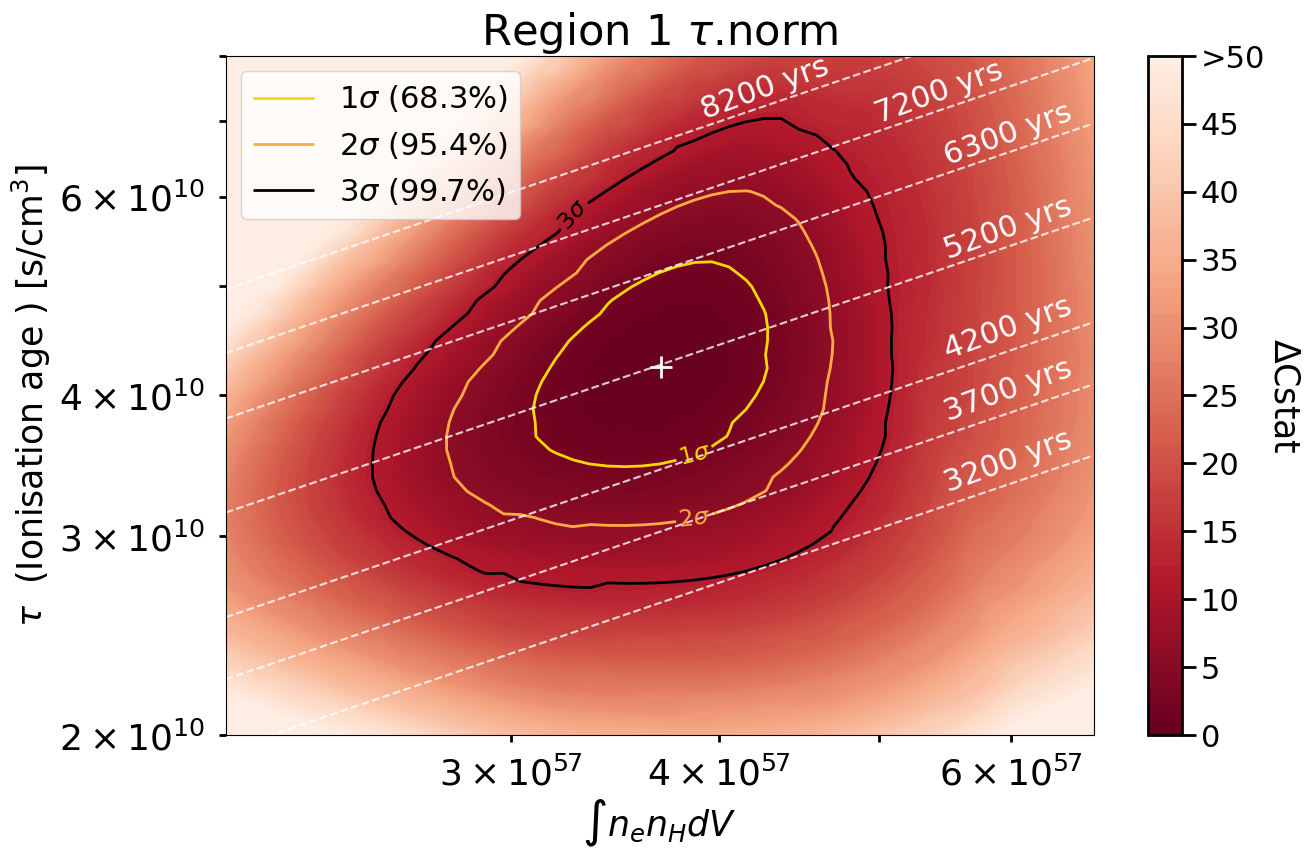

In [11]:
z = np.genfromtxt('../data/analysis/region1/contlog_ntau_yp_m128_02_25_c329_d277.qdp',unpack=True,skip_header=2)
z -= np.min(z) # normalisation for delta C

x_low = 3e-3
x_high = 1e-2
y_low = 2e10
y_high = 8e10
xp=5.49037009E-3
yp=4.24E+10

#Linear
# x = np.arange(x_low,x_high+(x_high-x_low)/(len(z[0])-1)/2,(x_high-x_low)/(len(z[0])-1))
# y = np.arange(y_low,y_high+(y_high-y_low)/(len(z)-1)/2,(y_high-y_low)/(len(z)-1))

#Logarithmic
x = np.logspace(np.log10(x_low),np.log10(x_high),len(z[0]))
y = np.logspace(np.log10(y_low),np.log10(y_high),len(z[0]))

xp=norm_transform(xp)
x_low=norm_transform(x_low)
x_high=norm_transform(x_high)
x = norm_transform(x)
print('xp,yp=',xp,yp)

cstat = np.min(z)
z[z>50]=50

cstat1=2.3
cstat2=6.17
cstat3=11.8
levels=np.array([cstat1,cstat2,cstat3])
print(levels)

plt.clf()

plt.figure(figsize=(14,9),dpi=100, facecolor='w', edgecolor='k')
plt.plot(xp,yp,"+",markersize=16,markeredgewidth=2, color="white")

labels = [r"$1\sigma$ $(68.3\%)$",r"$2\sigma$ $(90\%)$" ,r"$3\sigma$ $(99\%)$"]
only_sigma_labels =  [r"$1\sigma$",r"$2\sigma$" ,r"$3\sigma$"]


# cs = plt.contour(x,y,z,levels,linewidths=2,colors=('black', 'black', 'black'))
cs = plt.contour(x,y,z,levels,linewidths=2,colors=('#FFD600', '#FFAB40', 'black'))

k = 0.3

age=8200*u.yr
plt.plot(x,time_curves_k(x,volume_region1,age,k),'--',color='white',label=str(age.value),alpha=0.8)
plt.text(x[-16], time_curves_k(x,volume_region1,age,k)[-16].value*0.93, '{i} yrs'.format(i=int(age.value)), color='white',rotation=20,fontsize=22,ha='right')

age=7200*u.yr
plt.plot(x,time_curves_k(x,volume_region1,age,k),'--',color='white',label=str(age.value),alpha=0.8)
plt.text(x[-6], time_curves_k(x,volume_region1,age,k)[-6].value*0.93, '{i} yrs'.format(i=int(age.value)), color='white',rotation=20,fontsize=22,ha='right')

age=6300*u.yr
plt.plot(x,time_curves_k(x,volume_region1,age,k),'--',color='white',label=str(age.value),alpha=0.8)
plt.text(x[-2], time_curves_k(x,volume_region1,age,k)[-2].value*0.93, '{i} yrs'.format(i=int(age.value)), color='white',rotation=20,fontsize=22,ha='right')

age=5200*u.yr
plt.plot(x,time_curves_k(x,volume_region1,age,k),'--',color='white',label=str(age.value),alpha=0.8)
plt.text(x[-2], time_curves_k(x,volume_region1,age,k)[-2].value*0.93, '{i} yrs'.format(i=int(age.value)), color='white',rotation=20,fontsize=22,ha='right')

age=4200*u.yr
plt.plot(x,time_curves_k(x,volume_region1,age,k),'--',color='white',label=str(age.value),alpha=0.8)
plt.text(x[-2], time_curves_k(x,volume_region1,age,k)[-2].value*0.94, '{i} yrs'.format(i=int(age.value)), color='white',rotation=20,fontsize=22,ha='right')

age=3700*u.yr
plt.plot(x,time_curves_k(x,volume_region1,age,k),'--',color='white',label=str(age.value),alpha=0.8)
plt.text(x[-2], time_curves_k(x,volume_region1,age,k)[-2].value*0.94, '{i} yrs'.format(i=int(age.value)), color='white',rotation=20,fontsize=22,ha='right')

age=3200*u.yr
plt.plot(x,time_curves_k(x,volume_region1,age,k),'--',color='white',label=str(age.value),alpha=0.8)
plt.text(x[-2], time_curves_k(x,volume_region1,age,k)[-2].value*0.94, '{i} yrs'.format(i=int(age.value)), color='white',rotation=20,fontsize=22,ha='right')


# plt.text(1,1,'1300 years', color="white", fontsize=18)

fmt = {}
for l, s in zip(cs.levels, only_sigma_labels):
    fmt[l] = s

plt.clabel(cs, cs.levels, inline=True, fontsize=17,fmt=fmt)


plt.contourf(x,y,z,  100, cmap=cmap, vmin=0,vmax=50)
plt.contourf(x,y,z,  100, cmap=cmap, vmin=0,vmax=50) #magical solution - plot 2 times and get image without white lines

ax = plt.gca()
plt.rcParams.update({'font.size': 26, 'xtick.labelsize':30, 'ytick.labelsize':30})
plt.rcParams.update({'axes.linewidth': '2'})
plt.tick_params(axis="both", pad=12,labelsize=26,size=10)
#plt.tick_params(axis="y", pad=12,labelsize=22,size=10)
plt.tick_params(which='minor', length=5, width=2,labelsize=26, pad=10)
plt.tick_params(which='major', length=10,width=2,labelsize=26)
plt.tick_params(axis='x', which='major', length=10,width=2,labelsize=28)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
plt.ylabel(r"$\tau \ $ (Ionisation age ) [s/cm$^3$]",fontsize=25)
plt.xlabel(r"$\int n_e n_H dV$",fontsize=25)
plt.xscale("log")
plt.yscale("log")
# plt.xlim(x_low,x_high)
plt.ylim(y_low,y_high)

lines = [ cs.collections[0], cs.collections[1], cs.collections[2]]
labels = [r"$1\sigma$ $(68.3\%)$",r"$2\sigma$ $(95.4\%)$" ,r"$3\sigma$ $(99.7\%)$"]
plt.legend(lines, labels,loc=2,frameon=True,prop={'size':22})

cbar=plt.colorbar(fraction=0.15,spacing='proportional', ticks=ticks_values)
cbar.set_label(r'$\Delta$Cstat', rotation=270,size=25,labelpad=26)
cbar.ax.tick_params(labelsize=22,length=10,width=2) 
cbar.ax.set_yticklabels(tick_labels)
plt.title(r'Region 1 $\tau$.norm')

#plt.plot(np.unravel_index(z.argmin(), z.shape),"+")
plt.savefig("fig_cont_region1_tau03_norm.pdf", bbox_inches='tight')
plt.show()

## Region 2 - Tau.norm

xp,yp= 4.775251814412365e+56 16562299900.0
[ 2.3   6.17 11.8 ]


<Figure size 432x288 with 0 Axes>

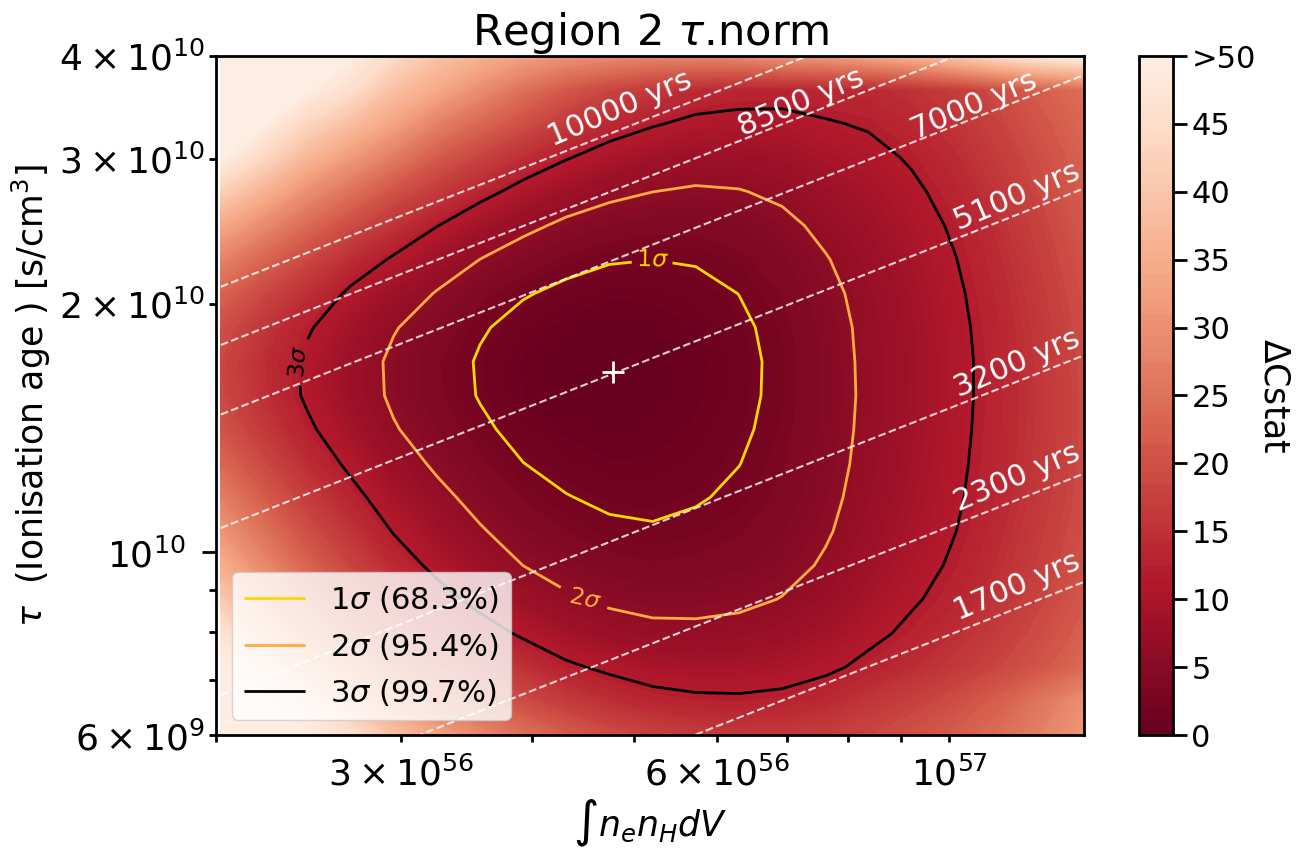

In [12]:
z = np.genfromtxt('../data/analysis/region2/contlog_ntau_gp_m12_03_08_c86_d104_cut5kev.qdp',unpack=True,skip_header=2)
z -= np.min(z) # normalisation for delta C

#steppar no log 21 0.3 3.5 50 log 35 1e9 5e13 50
x_low = 3e-4
x_high = 2e-3
y_low = 6e9
y_high = 4e10
xp=7.09516986E-4
yp=1.65622999E+10

#Linear
# x = np.arange(x_low,x_high+(x_high-x_low)/(len(z[0])-1)/2,(x_high-x_low)/(len(z[0])-1))
# y = np.arange(y_low,y_high+(y_high-y_low)/(len(z)-1)/2,(y_high-y_low)/(len(z)-1))

#Logarithmic
x = np.logspace(np.log10(x_low),np.log10(x_high),len(z[0]))
y = np.logspace(np.log10(y_low),np.log10(y_high),len(z[0]))

xp=norm_transform(xp)
x_low=norm_transform(x_low)
x_high=norm_transform(x_high)
x = norm_transform(x)
print('xp,yp=',xp,yp)


z[z>50]=50
cstat1=2.3
cstat2=6.17
cstat3=11.8
levels=np.array([cstat1,cstat2,cstat3])
print(levels)

plt.clf()

plt.figure(figsize=(14,9),dpi=100, facecolor='w', edgecolor='k')
plt.plot(xp,yp,"+",markersize=16,markeredgewidth=2, color="white")

labels = [r"$1\sigma$ $(68.3\%)$",r"$2\sigma$ $(90\%)$" ,r"$3\sigma$ $(99\%)$"]
only_sigma_labels =  [r"$1\sigma$",r"$2\sigma$" ,r"$3\sigma$"]


# cs = plt.contour(x,y,z,levels,linewidths=2,colors=('black', 'black', 'black'))
cs = plt.contour(x,y,z,levels,linewidths=2,colors=('#FFD600', '#FFAB40', 'black'))

k=0.3
age = 10000 *u.yr
plt.plot(x,time_curves_k(x,volume_region2,age,k),'--',color='white',label=str(age.value),alpha=0.8)
plt.text(x[-10], time_curves_k(x,volume_region2,age,k)[-10].value*0.88, '{i} yrs'.format(i=int(age.value)), color='white',rotation=23,fontsize=22,ha='right')

age = 8500 *u.yr
plt.plot(x,time_curves_k(x,volume_region2,age,k),'--',color='white',label=str(age.value),alpha=0.8)
plt.text(x[-6], time_curves_k(x,volume_region2,age,k)[-6].value*0.88, '{i} yrs'.format(i=int(age.value)), color='white',rotation=23,fontsize=22,ha='right')

age = 7000 *u.yr
plt.plot(x,time_curves_k(x,volume_region2,age,k),'--',color='white',label=str(age.value),alpha=0.8)
plt.text(x[-2], time_curves_k(x,volume_region2,age,k)[-3].value*0.92, '{i} yrs'.format(i=int(age.value)), color='white',rotation=23,fontsize=22,ha='right')


ages = np.array([5100, 3200])*u.yr
for age in ages:#     age = time * u.year
    plt.plot(x,time_curves_k(x,volume_region2,age,k),'--',color='white',label=str(age.value),alpha=0.8)
    plt.text(x[-1], time_curves_k(x,volume_region2,age,k)[-1].value*0.89, '{i} yrs'.format(i=int(age.value)), color='white',rotation=23,fontsize=22,ha='right')

ages = np.array([2300, 1700])*u.yr
for age in ages:#     age = time * u.year
    plt.plot(x,time_curves_k(x,volume_region2,age,k),'--',color='white',label=str(age.value),alpha=0.8)
    plt.text(x[-1], time_curves_k(x,volume_region2,age,k)[-1].value*0.9, '{i} yrs'.format(i=int(age.value)), color='white',rotation=23,fontsize=22,ha='right')

    
    

fmt = {}
for l, s in zip(cs.levels, only_sigma_labels):
    fmt[l] = s

plt.clabel(cs, cs.levels, inline=True, fontsize=17,fmt=fmt)


plt.contourf(x,y,z,  100, cmap=cmap, vmin=0,vmax=50)
plt.contourf(x,y,z,  100, cmap=cmap, vmin=0,vmax=50) #magical solution - plot 2 times and get image without white lines

ax = plt.gca()

plt.rcParams.update({'font.size': 26, 'xtick.labelsize':30, 'ytick.labelsize':30})
plt.rcParams.update({'axes.linewidth': '2'})
plt.tick_params(axis="both", pad=12,labelsize=26,size=10)
#plt.tick_params(axis="y", pad=12,labelsize=22,size=10)
plt.tick_params(which='minor', length=5, width=2,labelsize=26)
plt.tick_params(which='major', length=10,width=2,labelsize=26)
plt.tick_params(axis='x', which='major', length=10,width=2,labelsize=28)
plt.tick_params(axis='x',which='minor', pad=19)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
plt.ylabel(r"$\tau \ $ (Ionisation age ) [s/cm$^3$]",fontsize=25)
# plt.xlabel(r"Normalisation",fontsize=25)
plt.xlabel(r"$\int n_e n_H dV$",fontsize=25)
plt.xscale("log")
plt.yscale("log")
plt.xlim(x_low,x_high)
plt.ylim(y_low,y_high)

lines = [ cs.collections[0], cs.collections[1], cs.collections[2]]
labels = [r"$1\sigma$ $(68.3\%)$",r"$2\sigma$ $(95.4\%)$" ,r"$3\sigma$ $(99.7\%)$"]
plt.legend(lines, labels,loc=3,frameon=True,prop={'size':22})

cbar=plt.colorbar(fraction=0.15,spacing='proportional', ticks=ticks_values)
cbar.set_label(r'$\Delta$Cstat', rotation=270,size=25,labelpad=26)
cbar.ax.tick_params(labelsize=22,length=10,width=2) 
cbar.ax.set_yticklabels(tick_labels)
plt.title(r'Region 2 $\tau$.norm')


# tick_values = [2e56, 3e56, 4e56, 5e56, 6e56, 7e56, 8e56, 9e56, 1e57]
# tick_labels = [2e56, '' , 4e56, '', 6e56, '' , '' , '' , 1e57]
tick_values_x = [2e56, 3e56, 4e56, 5e56, 6e56, 7e56, 8e56, 9e56, 1e57]
tick_labels_x = ['', r'$3\times 10^{56}$', '' , '', r'$6\times 10^{56}$', '' , '' , '' , r'$10^{57}$']
ax.set_xticks(tick_values_x)
ax.xaxis.set_ticklabels(tick_labels_x)
plt.tick_params(axis='x',which='major', length=5, pad=10,labelsize=26)

#plt.plot(np.unravel_index(z.argmin(), z.shape),"+")
plt.savefig("fig_cont_region2_tau03_norm.pdf", bbox_inches='tight')
plt.show()

# Spectra (Fig.2 & 5)

In [35]:
### Data file structure
## Datapoints
# 0 - x (energy)
# 1 - x-err
# 2 - y (flux)
# 3 - y-err
# 4 - complete model
## Individual models
# 5 - model 1 - without soft protons
# 6 - model 2/3/4 - soft protons
## Individual components
# 7 - background power-law
# 8 - background apec
# 9 - 1.5keV calib line
# 10 - 1.74keV calib line
# 11 - 6.7keV calib line
# 12 - vnei plasma model

<Figure size 900x600 with 0 Axes>

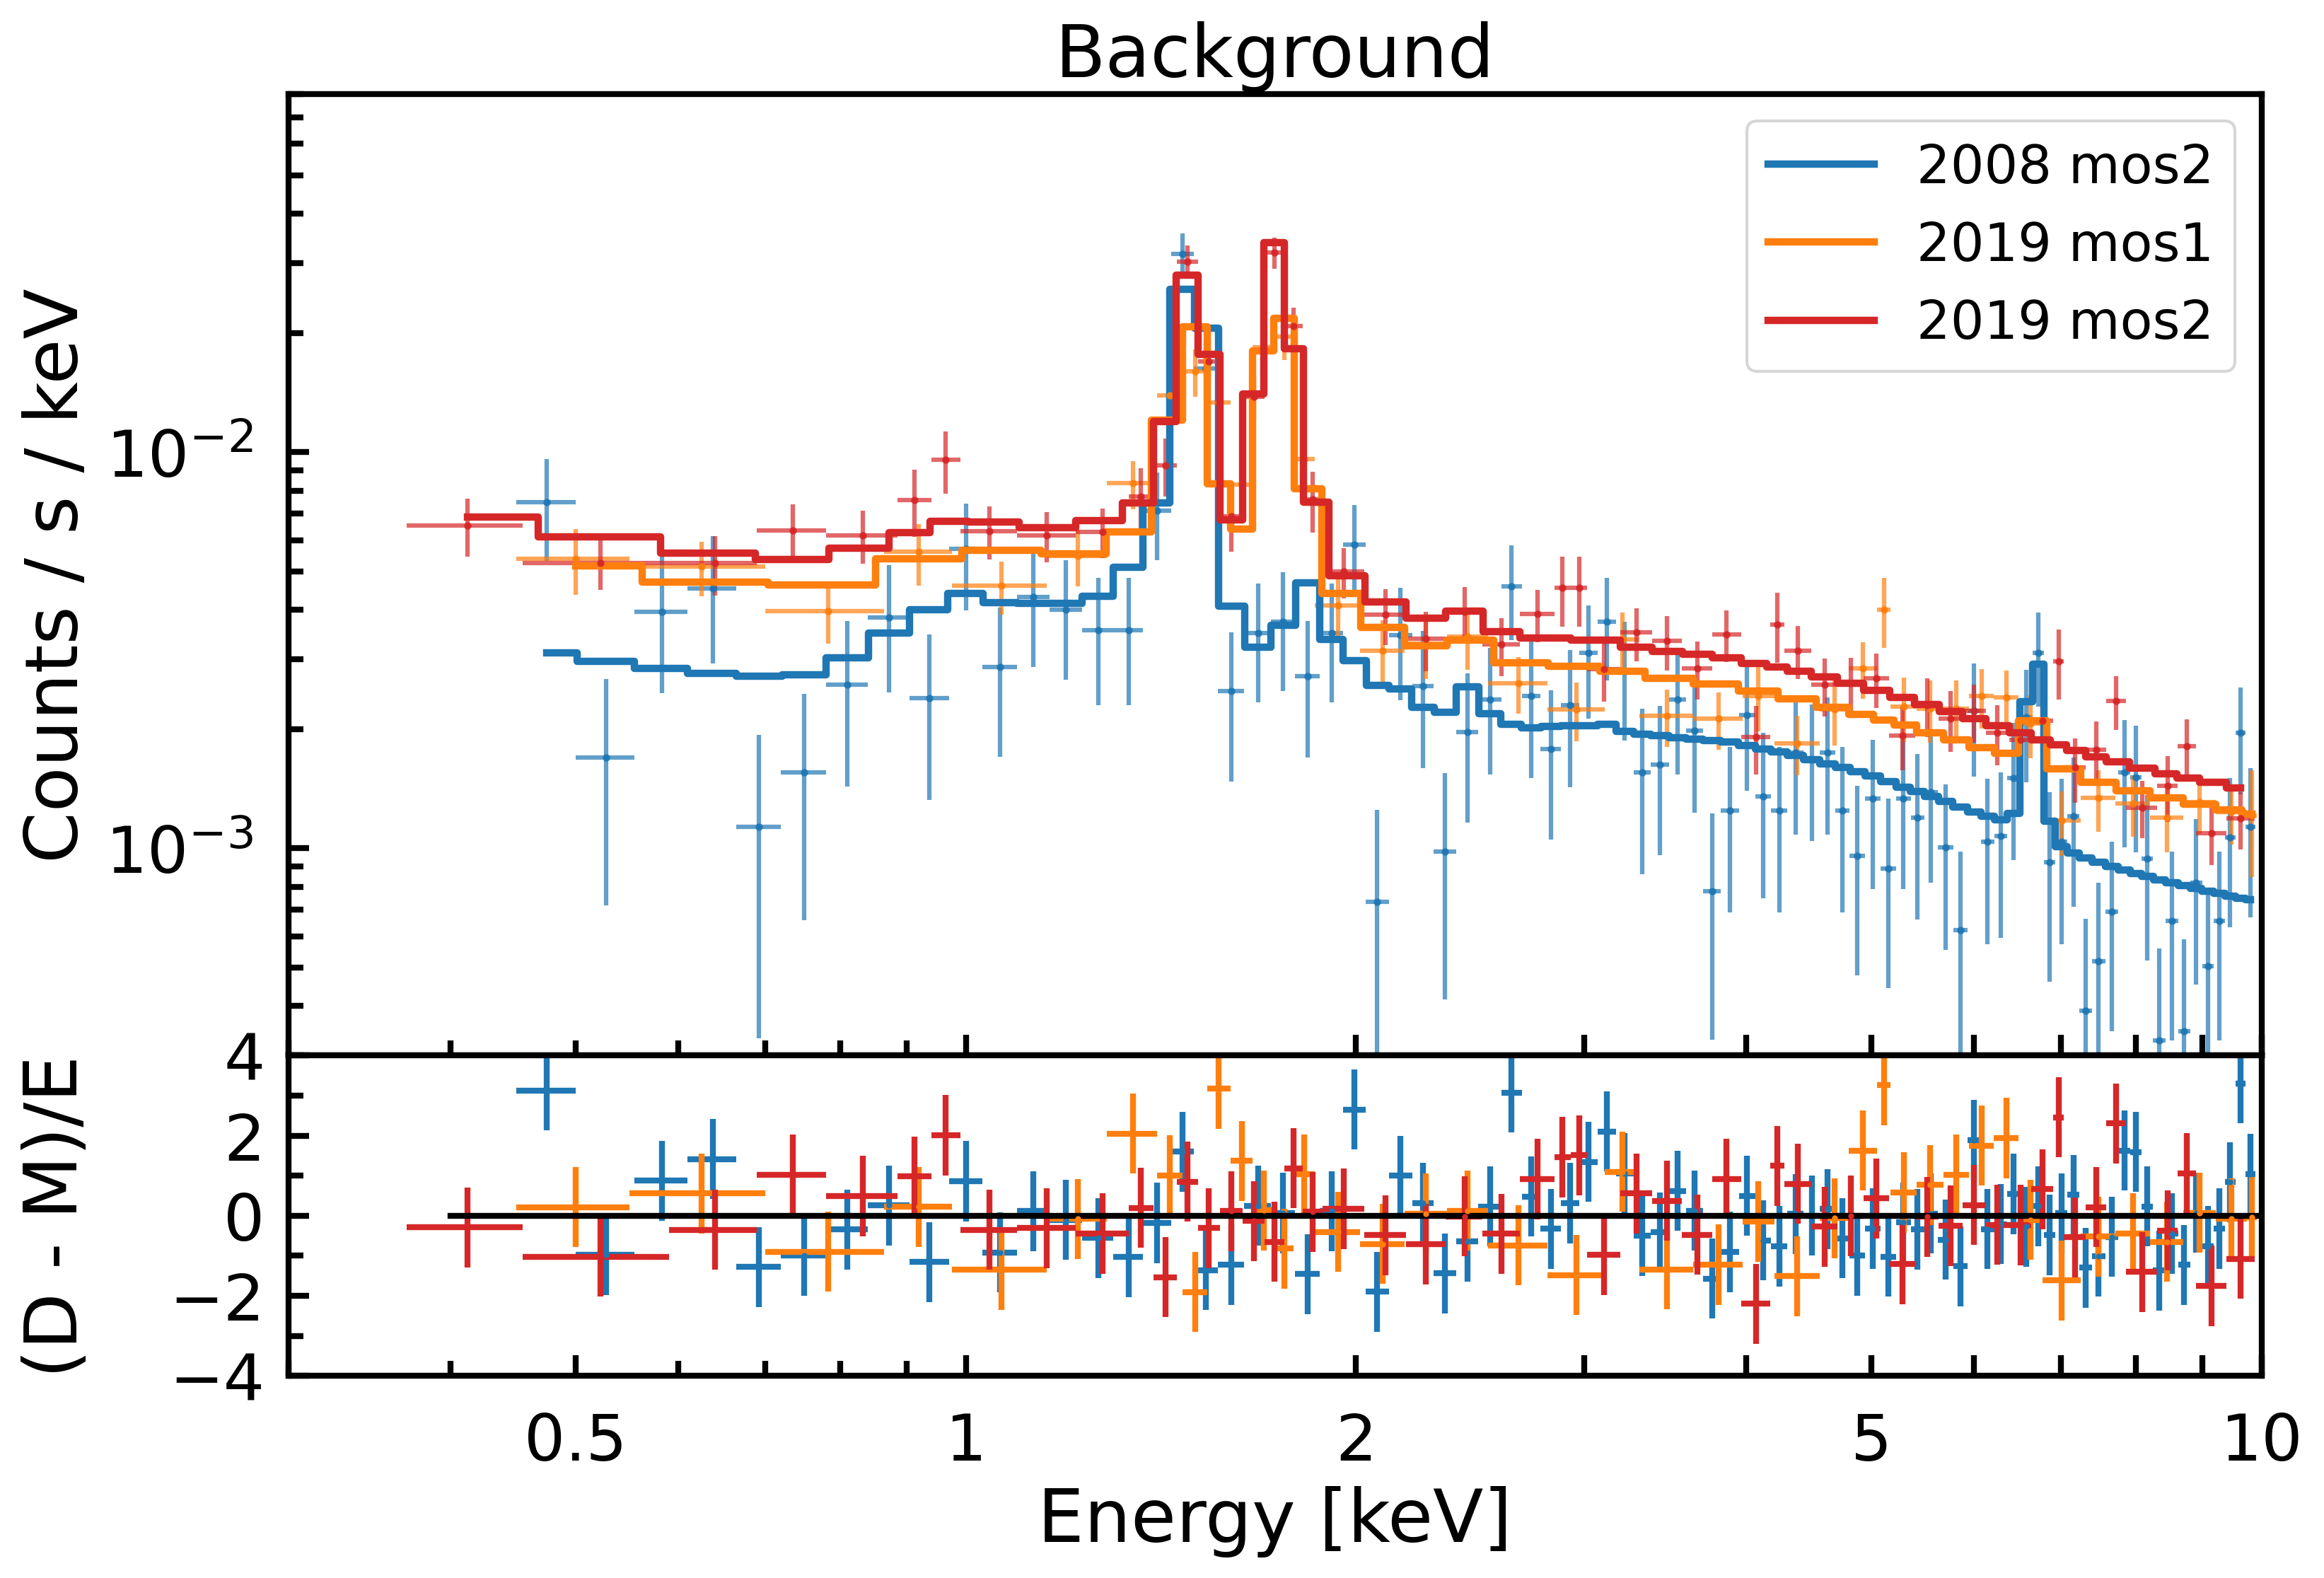

In [36]:
dat_19m1 = np.loadtxt('../data/analysis/background_g53/plt_mo_bkgbp_02_25_c306_d247_spec_19m1.dat', skiprows=1, unpack=True)
dat_19m2 = np.loadtxt('../data/analysis/background_g53/plt_mo_bkgbp_02_25_c306_d247_spec_19m2.dat', skiprows=1, unpack=True)
dat_08m2 = np.loadtxt('../data/analysis/background_g53/plt_mo_bkgbp_02_25_c306_d247_spec_08m2.dat', skiprows=1, unpack=True)

res_19m1 = np.loadtxt('../data/analysis/background_g53/plt_mo_bkgbp_02_25_c306_d247_res_19m1.dat', skiprows=1, unpack=True)
res_19m2 = np.loadtxt('../data/analysis/background_g53/plt_mo_bkgbp_02_25_c306_d247_res_19m2.dat', skiprows=1, unpack=True)
res_08m2 = np.loadtxt('../data/analysis/background_g53/plt_mo_bkgbp_02_25_c306_d247_res_08m2.dat', skiprows=1, unpack=True)

plt.clf()
plt.rcParams.update({'axes.titlesize': 'large',
                    'axes.linewidth': '2'})

fig = plt.figure(num=None, figsize=(12,8), dpi=300, facecolor='w', edgecolor='k')
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=4,rowspan=3)
plt.title('Background',fontsize=25)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.3,10)
ax1.set_ylim(3e-4,8e-2)

ax1.plot(dat_08m2[0],dat_08m2[2],'.',color="C0",ms=3,alpha=0.9)
ax1.errorbar(dat_08m2[0],dat_08m2[2],xerr=dat_08m2[1],yerr=dat_08m2[3],fmt="none",ecolor="C0",capsize=0,lod=True,lw=1.5,alpha=0.7)
ax1.step(dat_08m2[0],dat_08m2[4],'-',color="C0",alpha=1,ms=3,lw=2.5,where="mid",label="2008 mos2") 

ax1.plot(dat_19m1[0],dat_19m1[2],'.',color="C1",ms=3,alpha=0.9)
ax1.errorbar(dat_19m1[0],dat_19m1[2],xerr=dat_19m1[1],yerr=dat_19m1[3],fmt="none",ecolor="C1",capsize=0,lod=True,lw=1.5,alpha=0.7)
ax1.step(dat_19m1[0],dat_19m1[4],'-',color="C1",ms=3,alpha=1,lw=2.5,where="mid",label="2019 mos1") 

ax1.plot(dat_19m2[0],dat_19m2[2],'.',color="C3",ms=3,alpha=0.9)
ax1.errorbar(dat_19m2[0],dat_19m2[2],xerr=dat_19m2[1],yerr=dat_19m2[3],fmt="none",ecolor="C3",capsize=0,lod=True,lw=1.5,alpha=0.7)
ax1.step(dat_19m2[0],dat_19m2[4],'-',color="C3",ms=3,alpha=1,lw=2.5,where="mid",label="2019 mos2") 


ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_ticklabels([])

ax1.tick_params(axis="both", pad=12,labelsize=22,size=10, direction='in')
ax1.tick_params(which='minor', length=5,width=2,labelsize=16, direction='in')
ax1.tick_params(which='major', length=7,width=2, direction='in')


ax1.legend(prop={'size':18})
ax1.set_xlabel(r"Energy [keV]",fontsize=25)
ax1.set_ylabel("Counts / s / keV",fontsize=25)


ax2 = plt.subplot2grid((4, 4), (3, 0), colspan=4)
ax2.set_xscale('log')
ax2.set_yscale('linear')
ax2.set_xlim(0.3,10)
ax2.set_ylim(-4,4)
plt.subplots_adjust(hspace=0.)

ax2.xaxis.set_major_locator(MultipleLocator(1))
ax2.yaxis.set_major_locator(MultipleLocator(2))
ax2.yaxis.set_minor_locator(MultipleLocator(1))

tick_values = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
tick_labels = [0.5, 1, 2, "", "", 5, "", "", "", "", 10]
ax2.set_xticks(tick_values)
ax2.xaxis.set_ticklabels(tick_labels)

ax2.plot(res_08m2[0],res_08m2[2],'.',color="C0",ms=2)
ax2.errorbar(res_08m2[0],res_08m2[2],xerr=res_08m2[1],yerr=res_08m2[3],fmt="none",ecolor="C0",capsize=0,lod=True,lw=2)
ax2.plot([0.4,10.0],[0,0],color="black",lw=2)

ax2.plot(res_19m1[0],res_19m1[2],'.',color="C1",ms=2)
ax2.errorbar(res_19m1[0],res_19m1[2],xerr=res_19m1[1],yerr=res_19m1[3],fmt="none",ecolor="C1",capsize=0,lod=True,lw=2)

ax2.plot(res_19m2[0],res_19m2[2],'.',color="C3",ms=2)
ax2.errorbar(res_19m2[0],res_19m2[2],xerr=res_19m2[1],yerr=res_19m2[3],fmt="none",ecolor="C3",capsize=0,lod=True,lw=2)

ax2.set_xlabel(r'Energy [keV]',fontsize=25)
ax2.set_ylabel('(D - M)/E',fontsize=25, labelpad=26)

ax2.tick_params(axis="x", pad=12,labelsize=22,size=10, direction='in')
ax2.tick_params(axis="y", pad=8,labelsize=22, direction='in')
ax2.tick_params(axis='both', which='minor', length=5,width=2, direction='in')
ax2.tick_params(axis='both', which='major', length=7,width=2, direction='in')

plt.savefig('fig_spec_background.pdf', bbox_inches='tight')
plt.show()

<Figure size 900x600 with 0 Axes>

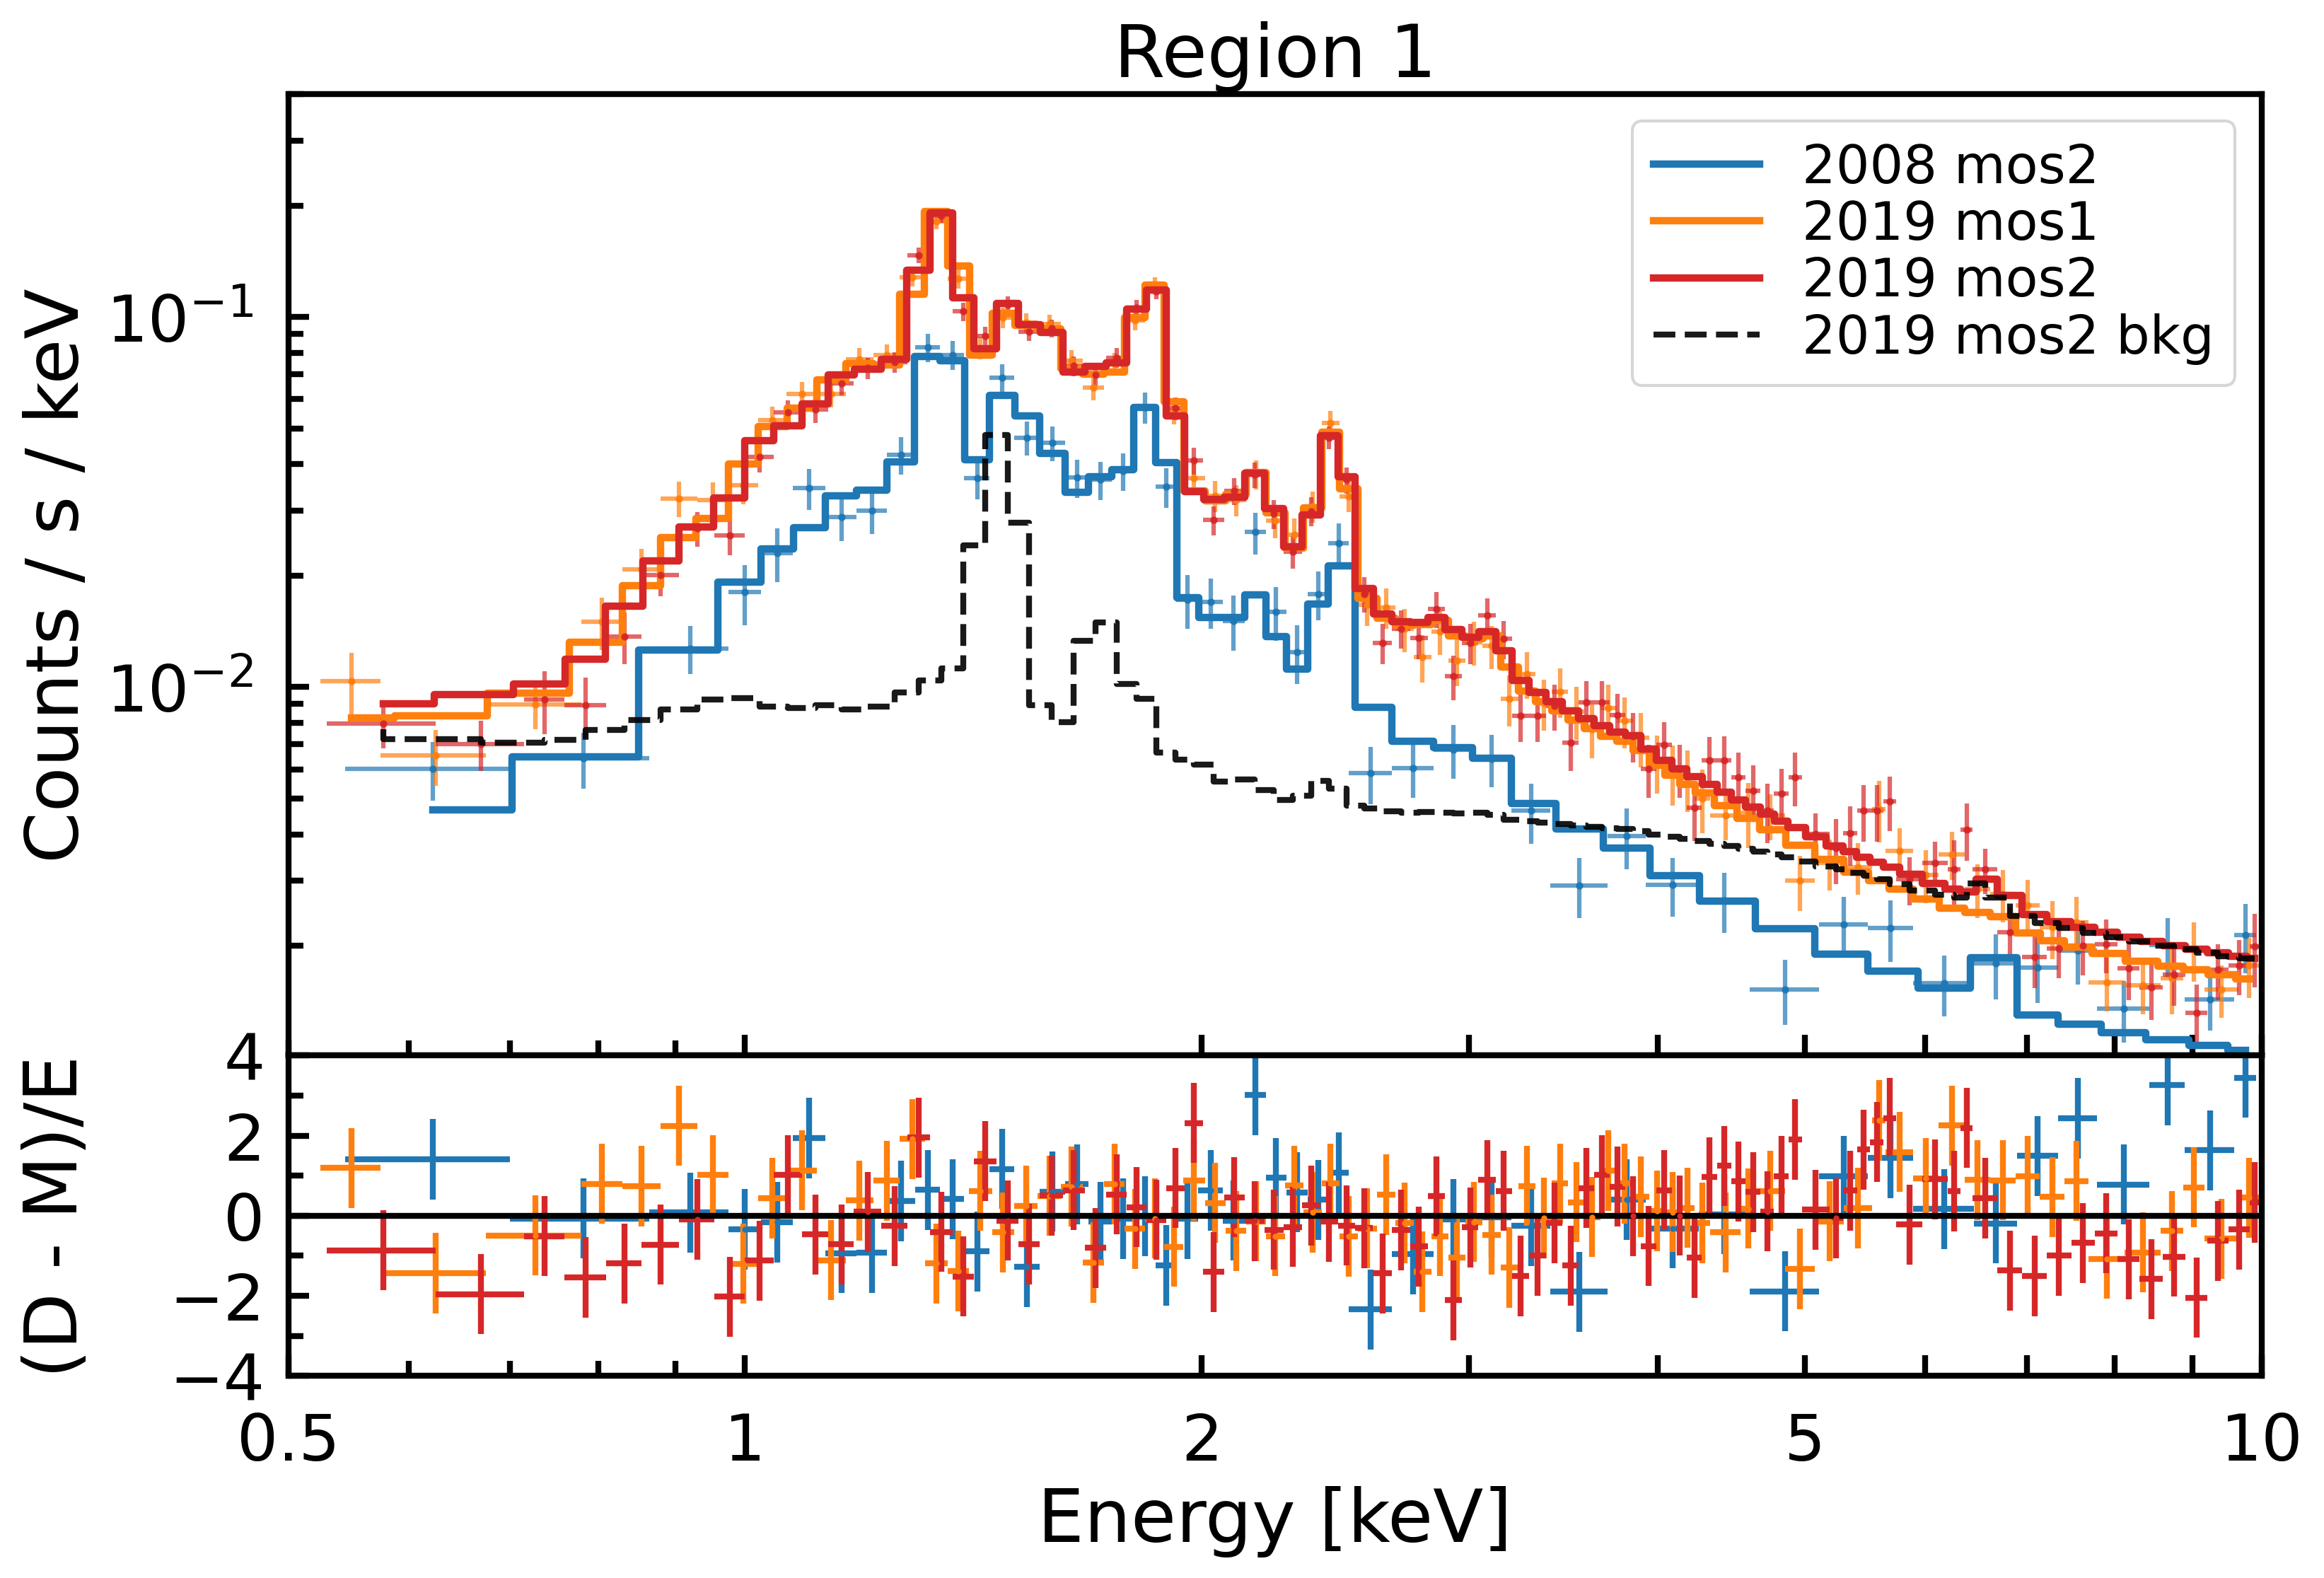

In [37]:
dat_19m1 = np.loadtxt('../data/analysis/region1/plt_mo_yp_m128_02_25_c329_d277_spec_19m1.dat', unpack=True)
dat_19m2 = np.loadtxt('../data/analysis/region1/plt_mo_yp_m128_02_25_c329_d277_spec_19m2.dat', unpack=True)
dat_08m2 = np.loadtxt('../data/analysis/region1/plt_mo_yp_m128_02_25_c329_d277_spec_08m2.dat', unpack=True)

res_19m1 = np.loadtxt('../data/analysis/region1/plt_mo_yp_m128_02_25_c329_d277_res_19m1.dat', unpack=True)
res_19m2 = np.loadtxt('../data/analysis/region1/plt_mo_yp_m128_02_25_c329_d277_res_19m2.dat', unpack=True)
res_08m2 = np.loadtxt('../data/analysis/region1/plt_mo_yp_m128_02_25_c329_d277_res_08m2.dat', unpack=True)

plt.clf()
plt.rcParams.update({'axes.titlesize': 'large',
                    'axes.linewidth': '2'})

fig = plt.figure(num=None, figsize=(12,8), dpi=300, facecolor='w', edgecolor='k')
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=4,rowspan=3)
plt.title('Region 1',fontsize=25)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.5,10)
ax1.set_ylim(1.01e-3,4e-1)

ax1.plot(dat_08m2[0],dat_08m2[2],'.',color="C0",ms=3,alpha=0.9)
ax1.errorbar(dat_08m2[0],dat_08m2[2],xerr=dat_08m2[1],yerr=dat_08m2[3],fmt="none",ecolor="C0",capsize=0,lod=True,lw=1.5,alpha=0.7)
ax1.step(dat_08m2[0],dat_08m2[4],'-',color="C0",alpha=1,ms=3,lw=2.5,where="mid",label="2008 mos2") 

ax1.plot(dat_19m1[0],dat_19m1[2],'.',color="C1",ms=3,alpha=0.9)
ax1.errorbar(dat_19m1[0],dat_19m1[2],xerr=dat_19m1[1],yerr=dat_19m1[3],fmt="none",ecolor="C1",capsize=0,lod=True,lw=1.5,alpha=0.7)
ax1.step(dat_19m1[0],dat_19m1[4],'-',color="C1",ms=3,alpha=1,lw=2.5,where="mid",label="2019 mos1") 

ax1.plot(dat_19m2[0],dat_19m2[2],'.',color="C3",ms=3,alpha=0.9)
ax1.errorbar(dat_19m2[0],dat_19m2[2],xerr=dat_19m2[1],yerr=dat_19m2[3],fmt="none",ecolor="C3",capsize=0,lod=True,lw=1.5,alpha=0.7)
ax1.step(dat_19m2[0],dat_19m2[4],'-',color="C3",ms=3,alpha=1,lw=2.5,where="mid",label="2019 mos2") 

bkg_08m2 = np.zeros_like(dat_08m2[0])
bkg_19m1 = np.zeros_like(dat_19m1[0])
bkg_19m2 = np.zeros_like(dat_19m2[0])

for i in range(6,12):
    bkg_08m2 += dat_08m2[i]
    bkg_19m1 += dat_19m1[i]
    bkg_19m2 += dat_19m2[i]

# ax1.step(dat_08m2[0], bkg_08m2,'--',color="C0",lw=1.5,alpha=0.9, label="bkg")
# ax1.step(dat_19m1[0], bkg_19m1,'--',color="C1",lw=1.5,alpha=0.9, label="bkg")
# ax1.step(dat_19m2[0], bkg_19m2,'--',color="C3",lw=1.5,alpha=0.9, label="bkg")
ax1.step(dat_19m2[0], bkg_19m2,'--',color="black",lw=2,alpha=0.9, label="2019 mos2 bkg")


ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_ticklabels([])

ax1.tick_params(axis="both", pad=12,labelsize=22,size=10, direction='in')
ax1.tick_params(which='minor', length=5,width=2,labelsize=16, direction='in')
ax1.tick_params(which='major', length=7,width=2, direction='in')


ax1.legend(prop={'size':18}, labelspacing=0.1, columnspacing=0.8)
ax1.set_xlabel(r"Energy [keV]",fontsize=25)
ax1.set_ylabel("Counts / s / keV",fontsize=25)


ax2 = plt.subplot2grid((4, 4), (3, 0), colspan=4)
ax2.set_xscale('log')
ax2.set_yscale('linear')
ax2.set_xlim(0.5,10)
ax2.set_ylim(-4,4)
plt.subplots_adjust(hspace=0.)

ax2.xaxis.set_major_locator(MultipleLocator(1))
ax2.yaxis.set_major_locator(MultipleLocator(2))
ax2.yaxis.set_minor_locator(MultipleLocator(1))

tick_values = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
tick_labels = [0.5, 1, 2, "", "", 5, "", "", "", "", 10]
ax2.set_xticks(tick_values)
ax2.xaxis.set_ticklabels(tick_labels)

ax2.plot(res_08m2[0],res_08m2[2],'.',color="C0",ms=2)
ax2.errorbar(res_08m2[0],res_08m2[2],xerr=res_08m2[1],yerr=res_08m2[3],fmt="none",ecolor="C0",capsize=0,lod=True,lw=2)
ax2.plot([0.4,10.0],[0,0],color="black",lw=2)

ax2.plot(res_19m1[0],res_19m1[2],'.',color="C1",ms=2)
ax2.errorbar(res_19m1[0],res_19m1[2],xerr=res_19m1[1],yerr=res_19m1[3],fmt="none",ecolor="C1",capsize=0,lod=True,lw=2)

ax2.plot(res_19m2[0],res_19m2[2],'.',color="C3",ms=2)
ax2.errorbar(res_19m2[0],res_19m2[2],xerr=res_19m2[1],yerr=res_19m2[3],fmt="none",ecolor="C3",capsize=0,lod=True,lw=2)

ax2.set_xlabel(r'Energy [keV]',fontsize=25)
ax2.set_ylabel('(D - M)/E',fontsize=25, labelpad=26)

ax2.tick_params(axis="x", pad=12,labelsize=22,size=10, direction='in')
ax2.tick_params(axis="y", pad=8,labelsize=22, direction='in')
ax2.tick_params(axis='both', which='minor', length=5,width=2, direction='in')
ax2.tick_params(axis='both', which='major', length=7,width=2, direction='in')

plt.savefig('fig_spec_region1.pdf', bbox_inches='tight')
plt.show()

<Figure size 900x600 with 0 Axes>

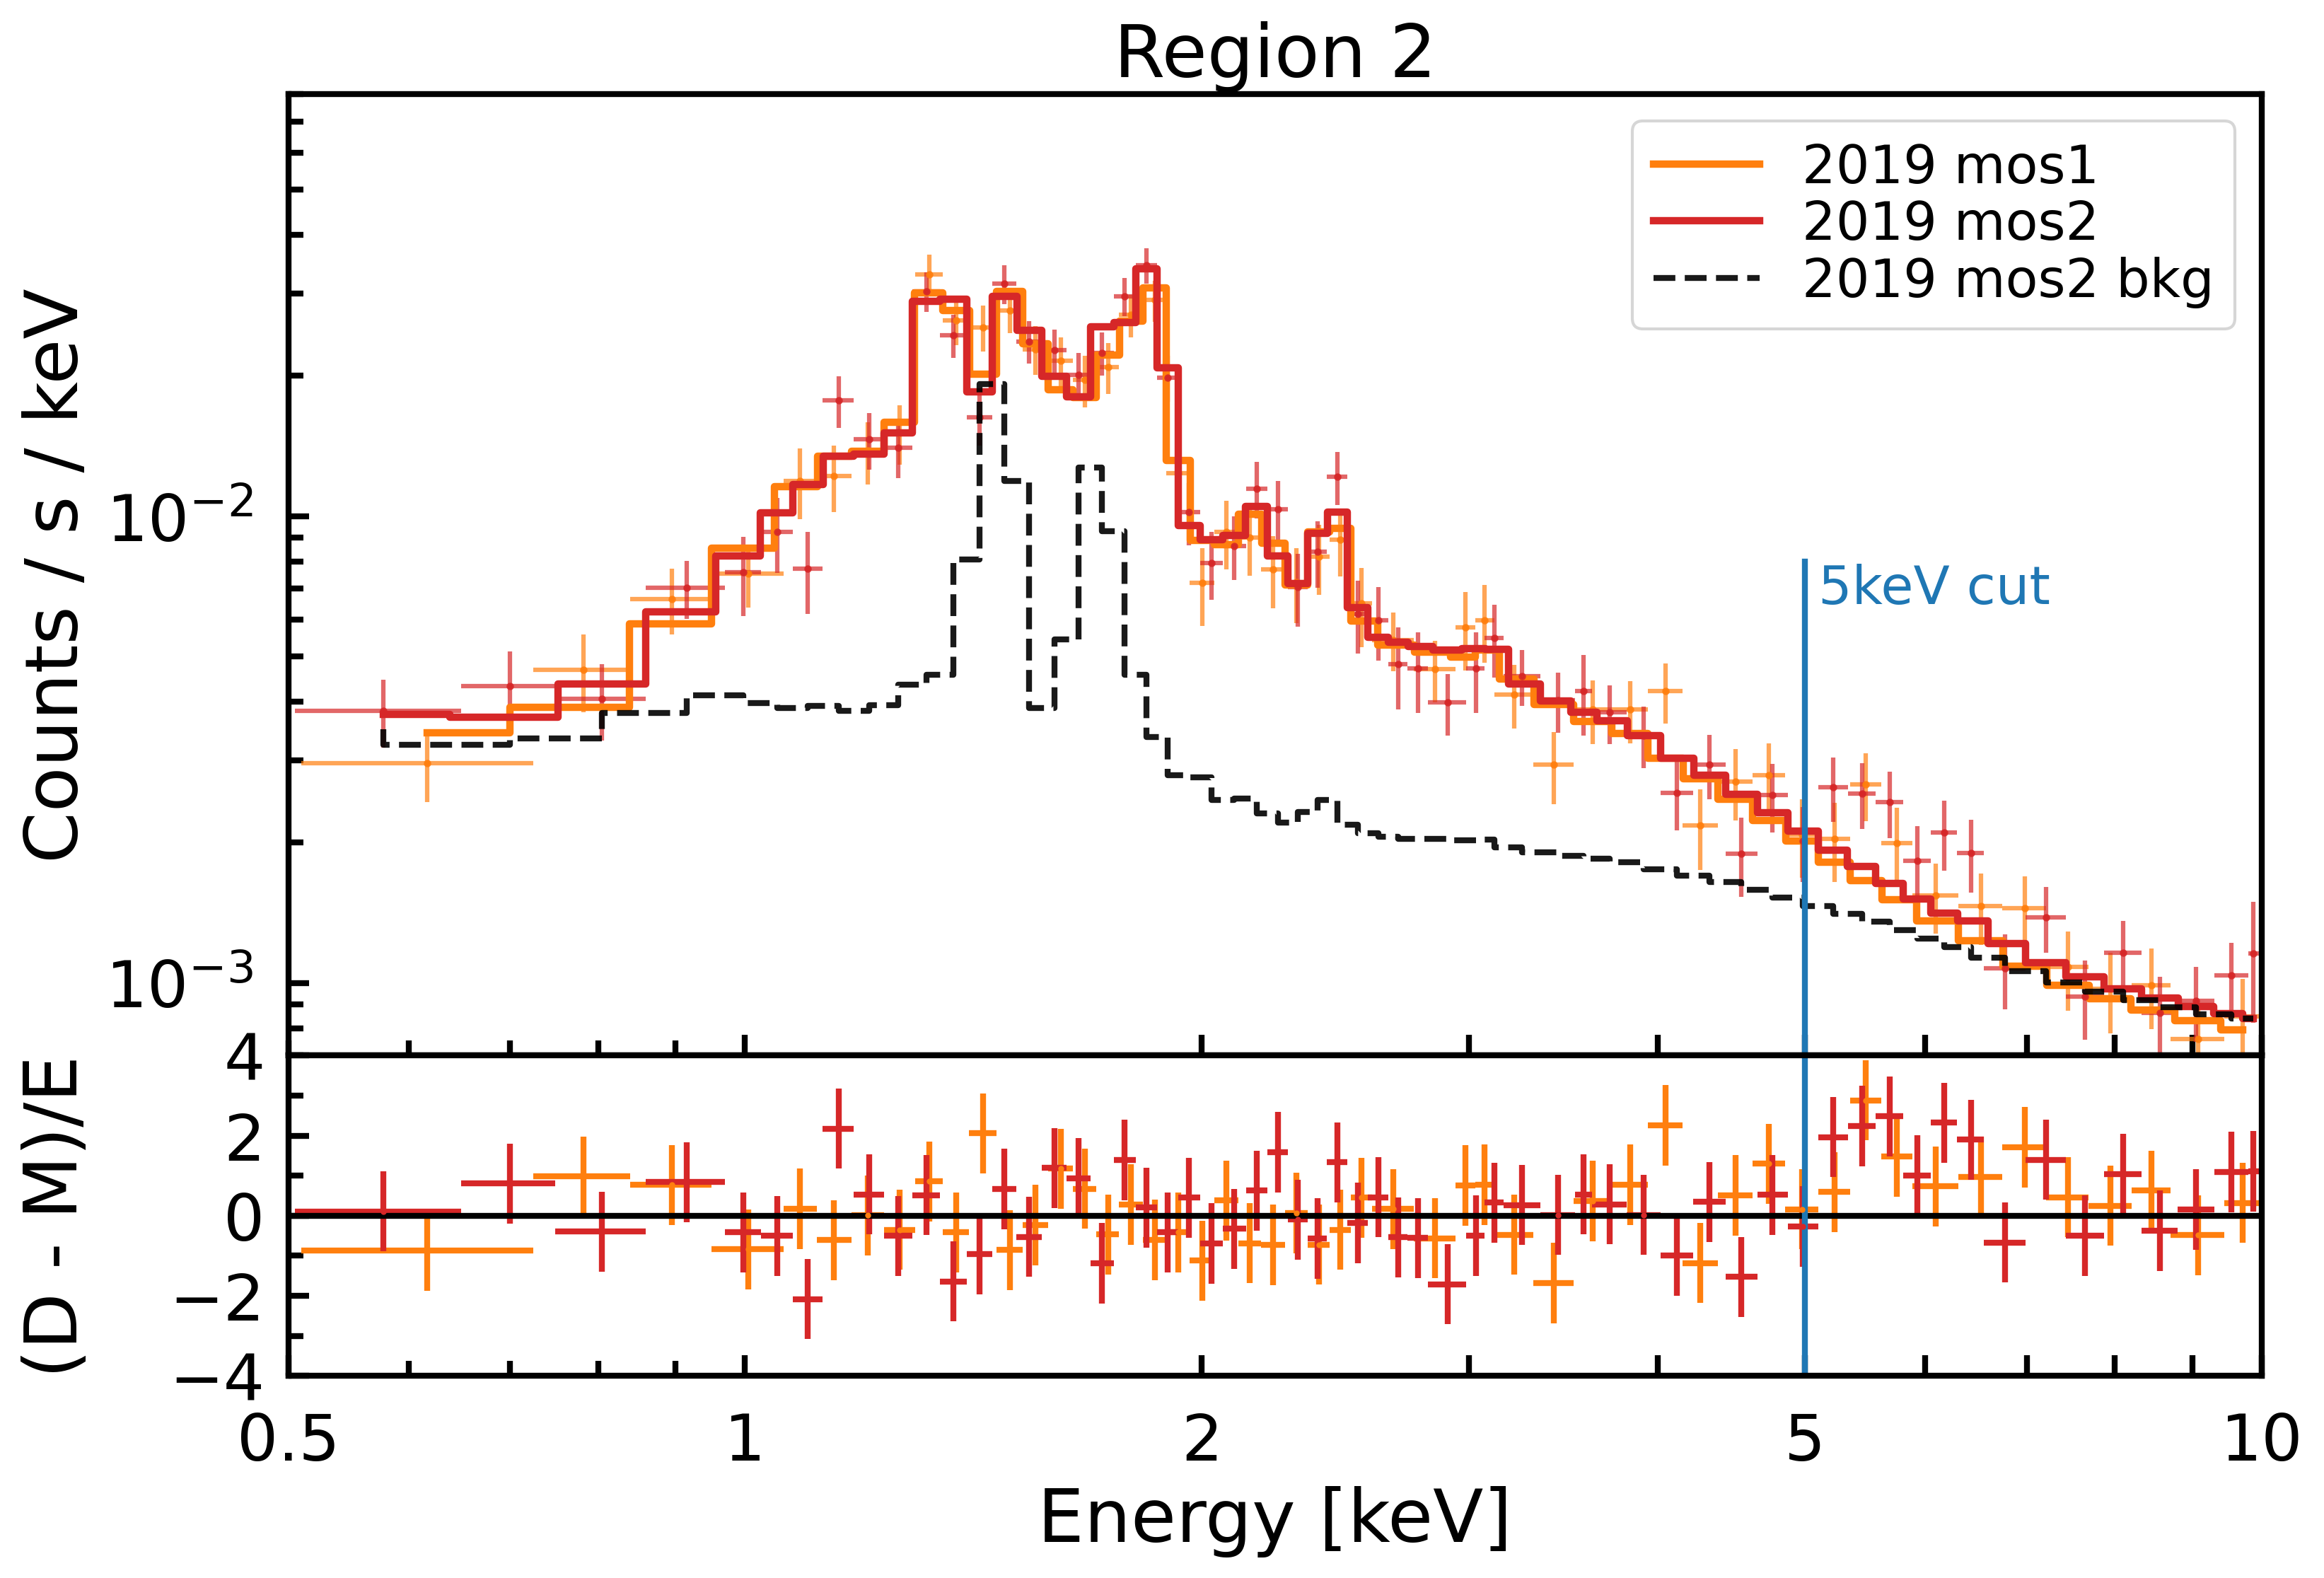

In [38]:
dat_19m1 = np.loadtxt('../data/analysis/region2/plt_mo_gp_m12_03_08_c86_d104_cut5kev_spec_19m1.dat', unpack=True)
dat_19m2 = np.loadtxt('../data/analysis/region2/plt_mo_gp_m12_03_08_c86_d104_cut5kev_spec_19m2.dat', unpack=True)

res_19m1 = np.loadtxt('../data/analysis/region2/plt_mo_gp_m12_03_08_c86_d104_cut5kev_res_19m1.dat', unpack=True)
res_19m2 = np.loadtxt('../data/analysis/region2/plt_mo_gp_m12_03_08_c86_d104_cut5kev_res_19m2.dat', unpack=True)
# res_08m2 = np.loadtxt(path_analysis + 'yellow_pie/plt_mo_yp_m128_02_25_c329_d277_res_08m2.dat', unpack=True)

plt.clf()
plt.rcParams.update({'axes.titlesize': 'large',
                    'axes.linewidth': '2'})

fig = plt.figure(num=None, figsize=(12,8), dpi=300, facecolor='w', edgecolor='k')
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=4,rowspan=3)
plt.title('Region 2',fontsize=25)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.5,10)
ax1.set_ylim(7e-4,8e-2)

# ax1.plot(dat_08m2[0],dat_08m2[2],'.',color="C0",ms=3,alpha=0.9)
# ax1.errorbar(dat_08m2[0],dat_08m2[2],xerr=dat_08m2[1],yerr=dat_08m2[3],fmt="none",ecolor="C0",capsize=0,lod=True,lw=1.5,alpha=0.7)
# ax1.step(dat_08m2[0],dat_08m2[4],'-',color="C0",alpha=1,ms=3,lw=2.5,where="mid",label="2008 mos2") 

ax1.plot(dat_19m1[0],dat_19m1[2],'.',color="C1",ms=3,alpha=0.9)
ax1.errorbar(dat_19m1[0],dat_19m1[2],xerr=dat_19m1[1],yerr=dat_19m1[3],fmt="none",ecolor="C1",capsize=0,lod=True,lw=1.5,alpha=0.7)
ax1.step(dat_19m1[0],dat_19m1[4],'-',color="C1",ms=3,alpha=1,lw=2.5,where="mid",label="2019 mos1") 

ax1.plot(dat_19m2[0],dat_19m2[2],'.',color="C3",ms=3,alpha=0.9)
ax1.errorbar(dat_19m2[0],dat_19m2[2],xerr=dat_19m2[1],yerr=dat_19m2[3],fmt="none",ecolor="C3",capsize=0,lod=True,lw=1.5,alpha=0.7)
ax1.step(dat_19m2[0],dat_19m2[4],'-',color="C3",ms=3,alpha=1,lw=2.5,where="mid",label="2019 mos2") 

# bkg_08m2 = np.zeros_like(dat_08m2[0])
bkg_19m1 = np.zeros_like(dat_19m1[0])
bkg_19m2 = np.zeros_like(dat_19m2[0])

for i in range(6,12):
#     bkg_08m2 += dat_08m2[i]
    bkg_19m1 += dat_19m1[i]
    bkg_19m2 += dat_19m2[i]

# ax1.step(dat_08m2[0], bkg_08m2,'--',color="C0",lw=1.5,alpha=0.9, label="bkg")
# ax1.step(dat_19m1[0], bkg_19m1,'--',color="C1",lw=1.5,alpha=0.9, label="bkg")
ax1.step(dat_19m2[0], bkg_19m2,'--',color="black",lw=2,alpha=0.9, label="2019 mos2 bkg")
ax1.plot([5.0,5.0],[7e-4,8e-3], '-', color="C0",lw=2)
ax1.text(5.1,6.5e-3, '5keV cut', color="C0", fontsize=18)

ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_ticklabels([])

ax1.tick_params(axis="both", pad=12,labelsize=22,size=10, direction='in')
ax1.tick_params(which='minor', length=5,width=2,labelsize=16, direction='in')
ax1.tick_params(which='major', length=7,width=2, direction='in')


ax1.legend(prop={'size':18}, labelspacing=0.1, columnspacing=0.8)
ax1.set_xlabel(r"Energy [keV]",fontsize=25)
ax1.set_ylabel("Counts / s / keV",fontsize=25)


ax2 = plt.subplot2grid((4, 4), (3, 0), colspan=4)
ax2.set_xscale('log')
ax2.set_yscale('linear')
ax2.set_xlim(0.5,10)
ax2.set_ylim(-4,4)
plt.subplots_adjust(hspace=0.)

ax2.xaxis.set_major_locator(MultipleLocator(1))
ax2.yaxis.set_major_locator(MultipleLocator(2))
ax2.yaxis.set_minor_locator(MultipleLocator(1))


tick_values = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
tick_labels = [0.5, 1, 2, "", "", 5, "", "", "", "", 10]
ax2.set_xticks(tick_values)
ax2.xaxis.set_ticklabels(tick_labels)

# ax2.plot(res_08m2[0],res_08m2[2],'.',color="C0",ms=2)
# ax2.errorbar(res_08m2[0],res_08m2[2],xerr=res_08m2[1],yerr=res_08m2[3],fmt="none",ecolor="C0",capsize=0,lod=True,lw=2)
ax2.plot([0.4,10.0],[0,0],color="black",lw=2)
ax2.plot([5.0,5.0],[-4,4], '-', color="C0",lw=2)

ax2.plot(res_19m1[0],res_19m1[2],'.',color="C1",ms=2)
ax2.errorbar(res_19m1[0],res_19m1[2],xerr=res_19m1[1],yerr=res_19m1[3],fmt="none",ecolor="C1",capsize=0,lod=True,lw=2)

ax2.plot(res_19m2[0],res_19m2[2],'.',color="C3",ms=2)
ax2.errorbar(res_19m2[0],res_19m2[2],xerr=res_19m2[1],yerr=res_19m2[3],fmt="none",ecolor="C3",capsize=0,lod=True,lw=2)

ax2.set_xlabel(r'Energy [keV]',fontsize=25)
ax2.set_ylabel('(D - M)/E',fontsize=25, labelpad=26)

ax2.tick_params(axis="x", pad=12,labelsize=22,size=10, direction='in')
ax2.tick_params(axis="y", pad=8,labelsize=22, direction='in')
ax2.tick_params(axis='both', which='minor', length=5,width=2, direction='in')
ax2.tick_params(axis='both', which='major', length=7,width=2, direction='in')

plt.savefig('fig_spec_region2.pdf', bbox_inches='tight')
plt.show()

<Figure size 900x600 with 0 Axes>

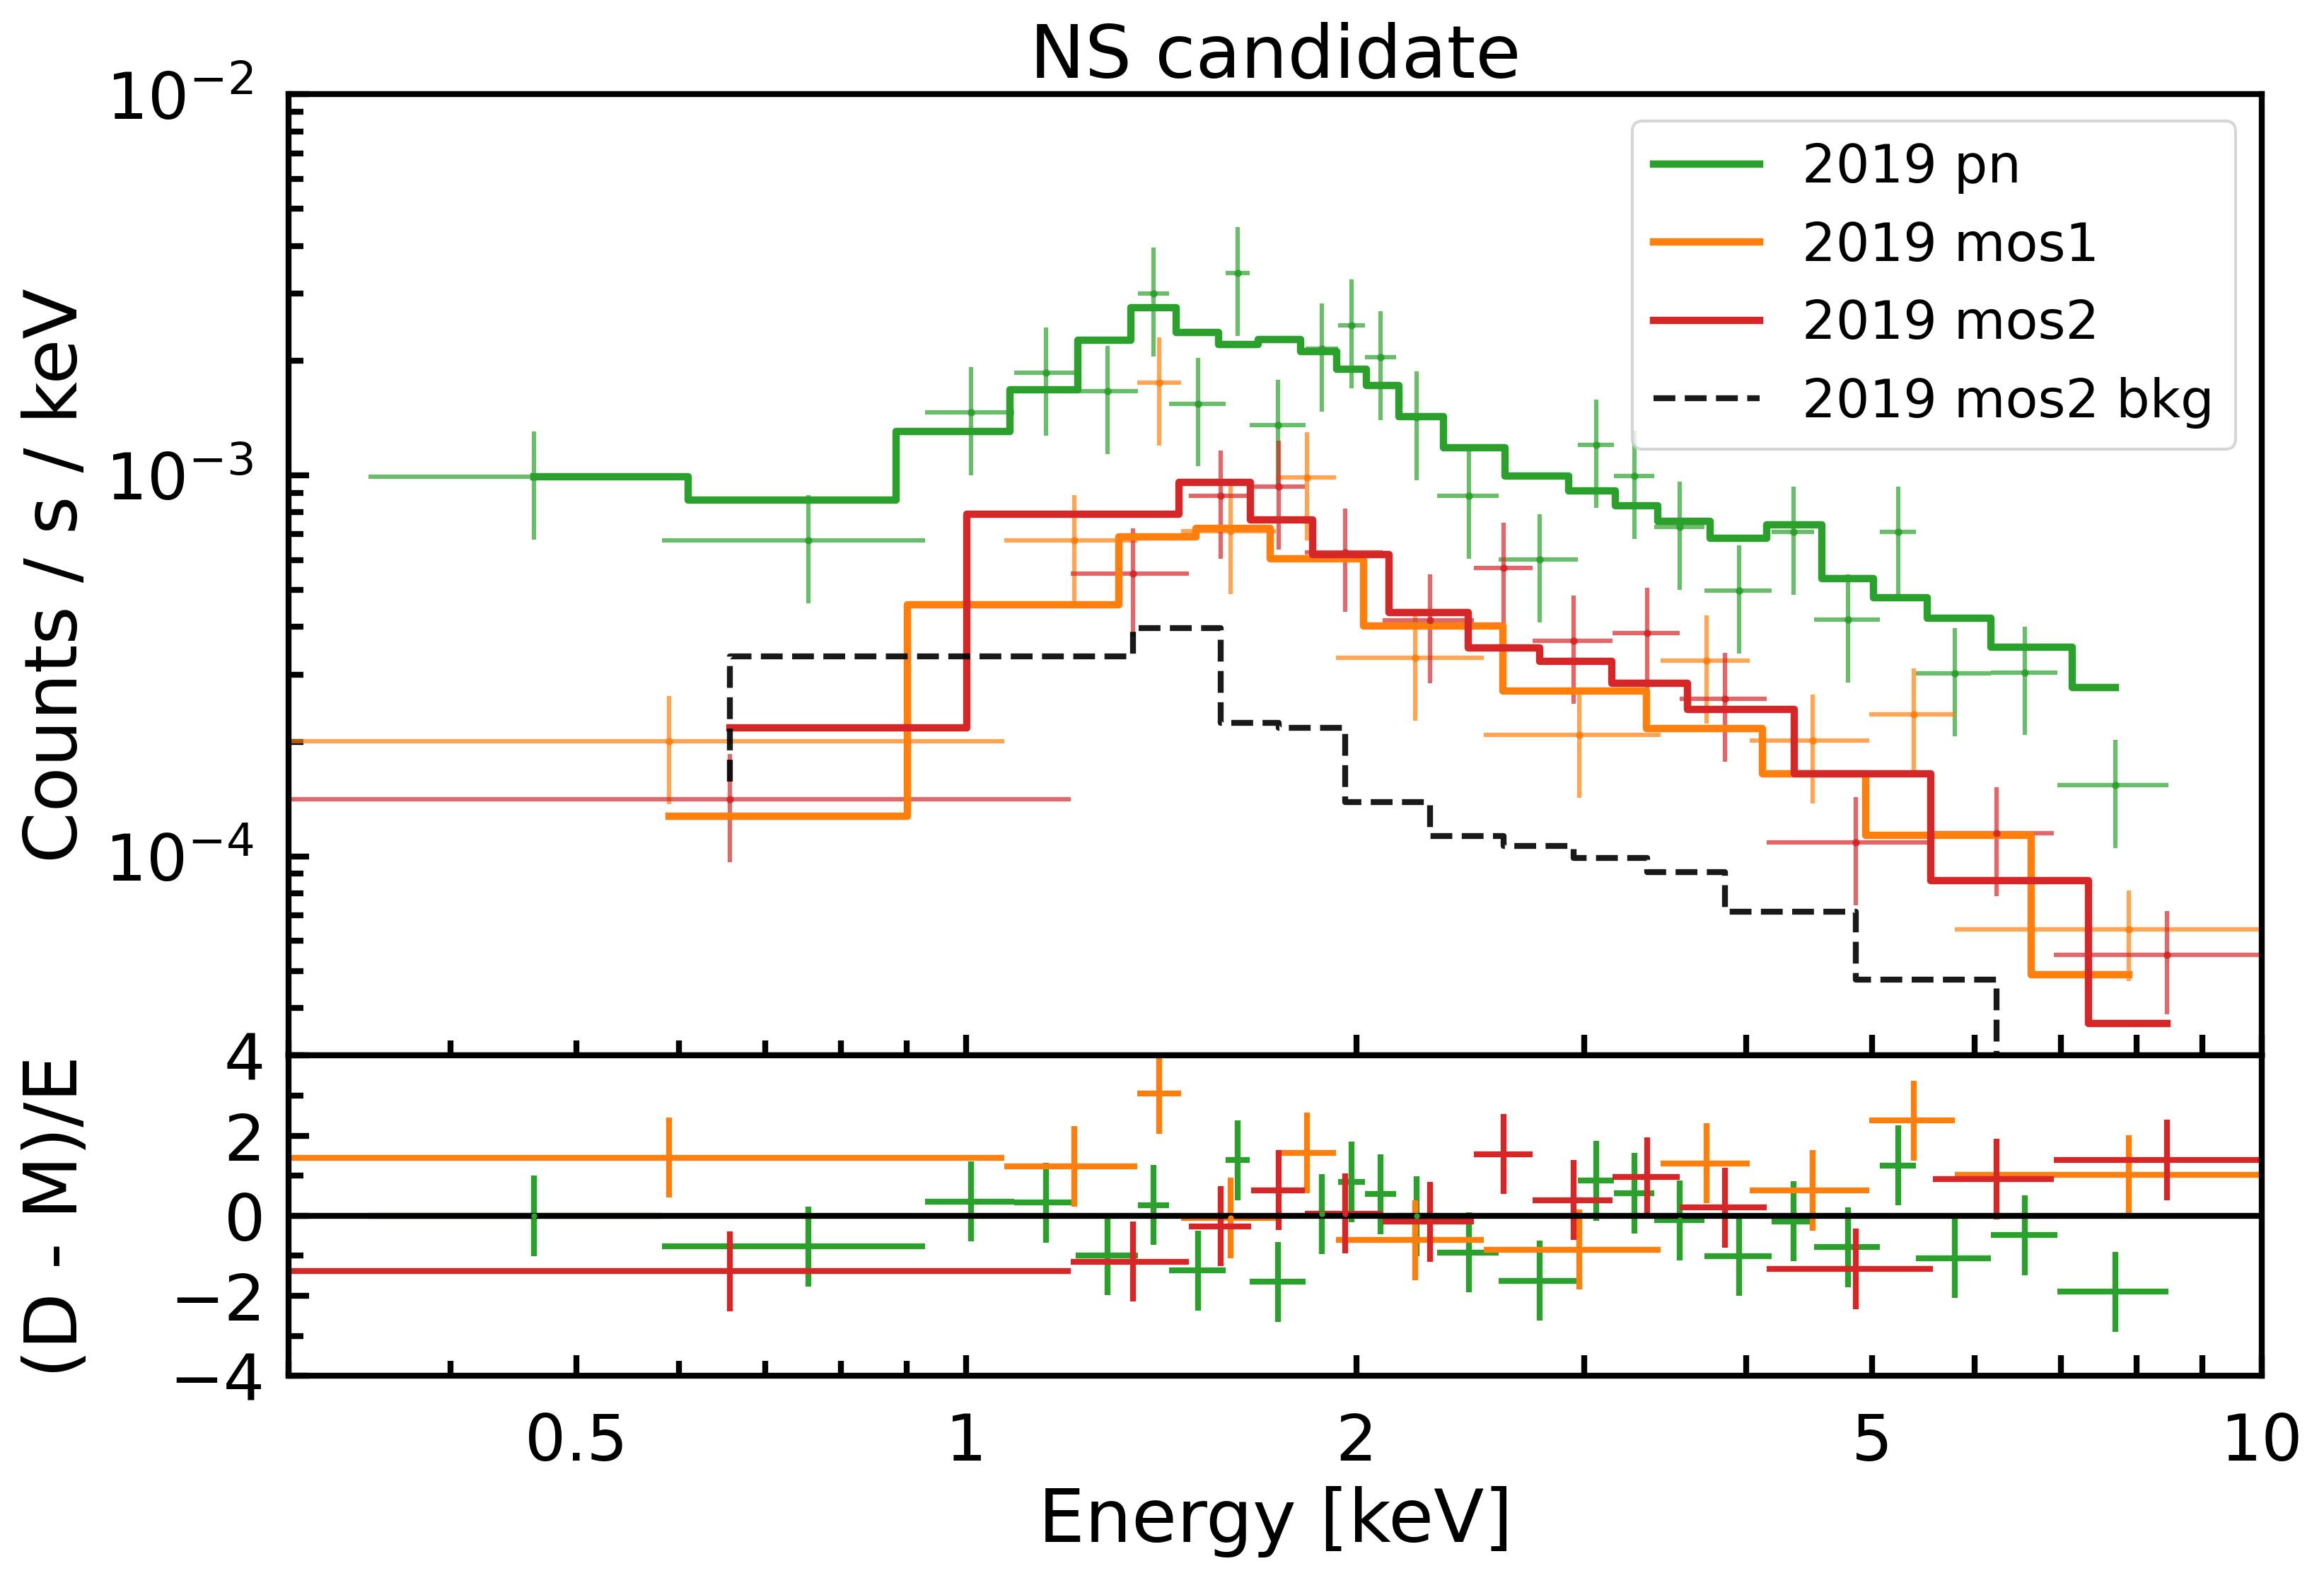

In [42]:
dat_19m1 = np.loadtxt('../data/analysis/PS1/plt_ps1_bkgfr_all_tbabs_pow_04_11_c56_d46_spec_19m1.dat', skiprows=0, unpack=True)
dat_19m2 = np.loadtxt('../data/analysis/PS1/plt_ps1_bkgfr_all_tbabs_pow_04_11_c56_d46_spec_19m2.dat', skiprows=0, unpack=True)
dat_19pn = np.loadtxt('../data/analysis/PS1/plt_ps1_bkgfr_all_tbabs_pow_04_11_c56_d46_spec_19pn.dat', skiprows=0, unpack=True)

res_19m1 = np.loadtxt('../data/analysis/PS1/plt_ps1_bkgfr_all_tbabs_pow_04_11_c56_d46_res_19m1.dat', skiprows=0, unpack=True)
res_19m2 = np.loadtxt('../data/analysis/PS1/plt_ps1_bkgfr_all_tbabs_pow_04_11_c56_d46_res_19m2.dat', skiprows=0, unpack=True)
res_19pn = np.loadtxt('../data/analysis/PS1/plt_ps1_bkgfr_all_tbabs_pow_04_11_c56_d46_res_19pn.dat', skiprows=0, unpack=True)

plt.clf()
plt.rcParams.update({'axes.titlesize': 'large',
                    'axes.linewidth': '2'})

fig = plt.figure(num=None, figsize=(12,8), dpi=300, facecolor='w', edgecolor='k')
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=4,rowspan=3)
plt.title('NS candidate',fontsize=25)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.3,10)
ax1.set_ylim(3e-5,1e-2)

ax1.plot(dat_19pn[0],dat_19pn[2],'.',color="C2",ms=3,alpha=0.9)
ax1.errorbar(dat_19pn[0],dat_19pn[2],xerr=dat_19pn[1],yerr=dat_19pn[3],fmt="none",ecolor="C2",capsize=0,lod=True,lw=1.5,alpha=0.7)
ax1.step(dat_19pn[0],dat_19pn[4],'-',color="C2",ms=3,alpha=1,lw=2.5,where="mid",label="2019 pn") 

ax1.plot(dat_19m1[0],dat_19m1[2],'.',color="C1",ms=3,alpha=0.9)
ax1.errorbar(dat_19m1[0],dat_19m1[2],xerr=dat_19m1[1],yerr=dat_19m1[3],fmt="none",ecolor="C1",capsize=0,lod=True,lw=1.5,alpha=0.7)
ax1.step(dat_19m1[0],dat_19m1[4],'-',color="C1",ms=3,alpha=1,lw=2.5,where="mid",label="2019 mos1") 

ax1.plot(dat_19m2[0],dat_19m2[2],'.',color="C3",ms=3,alpha=0.9)
ax1.errorbar(dat_19m2[0],dat_19m2[2],xerr=dat_19m2[1],yerr=dat_19m2[3],fmt="none",ecolor="C3",capsize=0,lod=True,lw=1.5,alpha=0.7)
ax1.step(dat_19m2[0],dat_19m2[4],'-',color="C3",ms=3,alpha=1,lw=2.5,where="mid",label="2019 mos2") 

bkg_19m1 = np.zeros_like(dat_19m1[0])
bkg_19m2 = np.zeros_like(dat_19m2[0])

for i in range(6,12):
#     bkg_08m2 += dat_08m2[i]
    bkg_19m1 += dat_19m1[i]
    bkg_19m2 += dat_19m2[i]

# ax1.step(dat_08m2[0], bkg_08m2,'--',color="C0",lw=1.5,alpha=0.9, label="bkg")
# ax1.step(dat_19m1[0], bkg_19m1,'--',color="C1",lw=1.5,alpha=0.9, label="bkg")
ax1.step(dat_19m2[0], bkg_19m2,'--',color="black",lw=2,alpha=0.9, label="2019 mos2 bkg")


ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_ticklabels([])

ax1.tick_params(axis="both", pad=12,labelsize=22,size=10, direction='in')
ax1.tick_params(which='minor', length=5,width=2,labelsize=16, direction='in')
ax1.tick_params(which='major', length=7,width=2, direction='in')


ax1.legend(prop={'size':18})
ax1.set_xlabel(r"Energy [keV]",fontsize=25)
ax1.set_ylabel("Counts / s / keV",fontsize=25)


ax2 = plt.subplot2grid((4, 4), (3, 0), colspan=4)
ax2.set_xscale('log')
ax2.set_yscale('linear')
ax2.set_xlim(0.3,10)
ax2.set_ylim(-4,4)
plt.subplots_adjust(hspace=0.)

ax2.xaxis.set_major_locator(MultipleLocator(1))
ax2.yaxis.set_major_locator(MultipleLocator(2))
ax2.yaxis.set_minor_locator(MultipleLocator(1))

tick_values = [0.5,1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
tick_labels = [0.5, 1, 2, "", "", 5, "", "", "", "", 10]
ax2.set_xticks(tick_values)
ax2.xaxis.set_ticklabels(tick_labels)


ax2.plot([0,10.0],[0,0],color="black",lw=2)

ax2.plot(res_19pn[0],res_19pn[2],'.',color="C2",ms=2)
ax2.errorbar(res_19pn[0],res_19pn[2],xerr=res_19pn[1],yerr=res_19pn[3],fmt="none",ecolor="C2",capsize=0,lod=True,lw=2)

ax2.plot(res_19m1[0],res_19m1[2],'.',color="C1",ms=2)
ax2.errorbar(res_19m1[0],res_19m1[2],xerr=res_19m1[1],yerr=res_19m1[3],fmt="none",ecolor="C1",capsize=0,lod=True,lw=2)

ax2.plot(res_19m2[0],res_19m2[2],'.',color="C3",ms=2)
ax2.errorbar(res_19m2[0],res_19m2[2],xerr=res_19m2[1],yerr=res_19m2[3],fmt="none",ecolor="C3",capsize=0,lod=True,lw=2)

ax2.set_xlabel(r'Energy [keV]',fontsize=25)
ax2.set_ylabel('(D - M)/E',fontsize=25, labelpad=26)

ax2.tick_params(axis="x", pad=12,labelsize=22,size=10, direction='in')
ax2.tick_params(axis="y", pad=8,labelsize=22, direction='in')
ax2.tick_params(axis='both', which='minor', length=5,width=2, direction='in')
ax2.tick_params(axis='both', which='major', length=7,width=2, direction='in')

plt.savefig('fig_spec_point_source_src.pdf', bbox_inches='tight')
plt.show()

<Figure size 900x600 with 0 Axes>

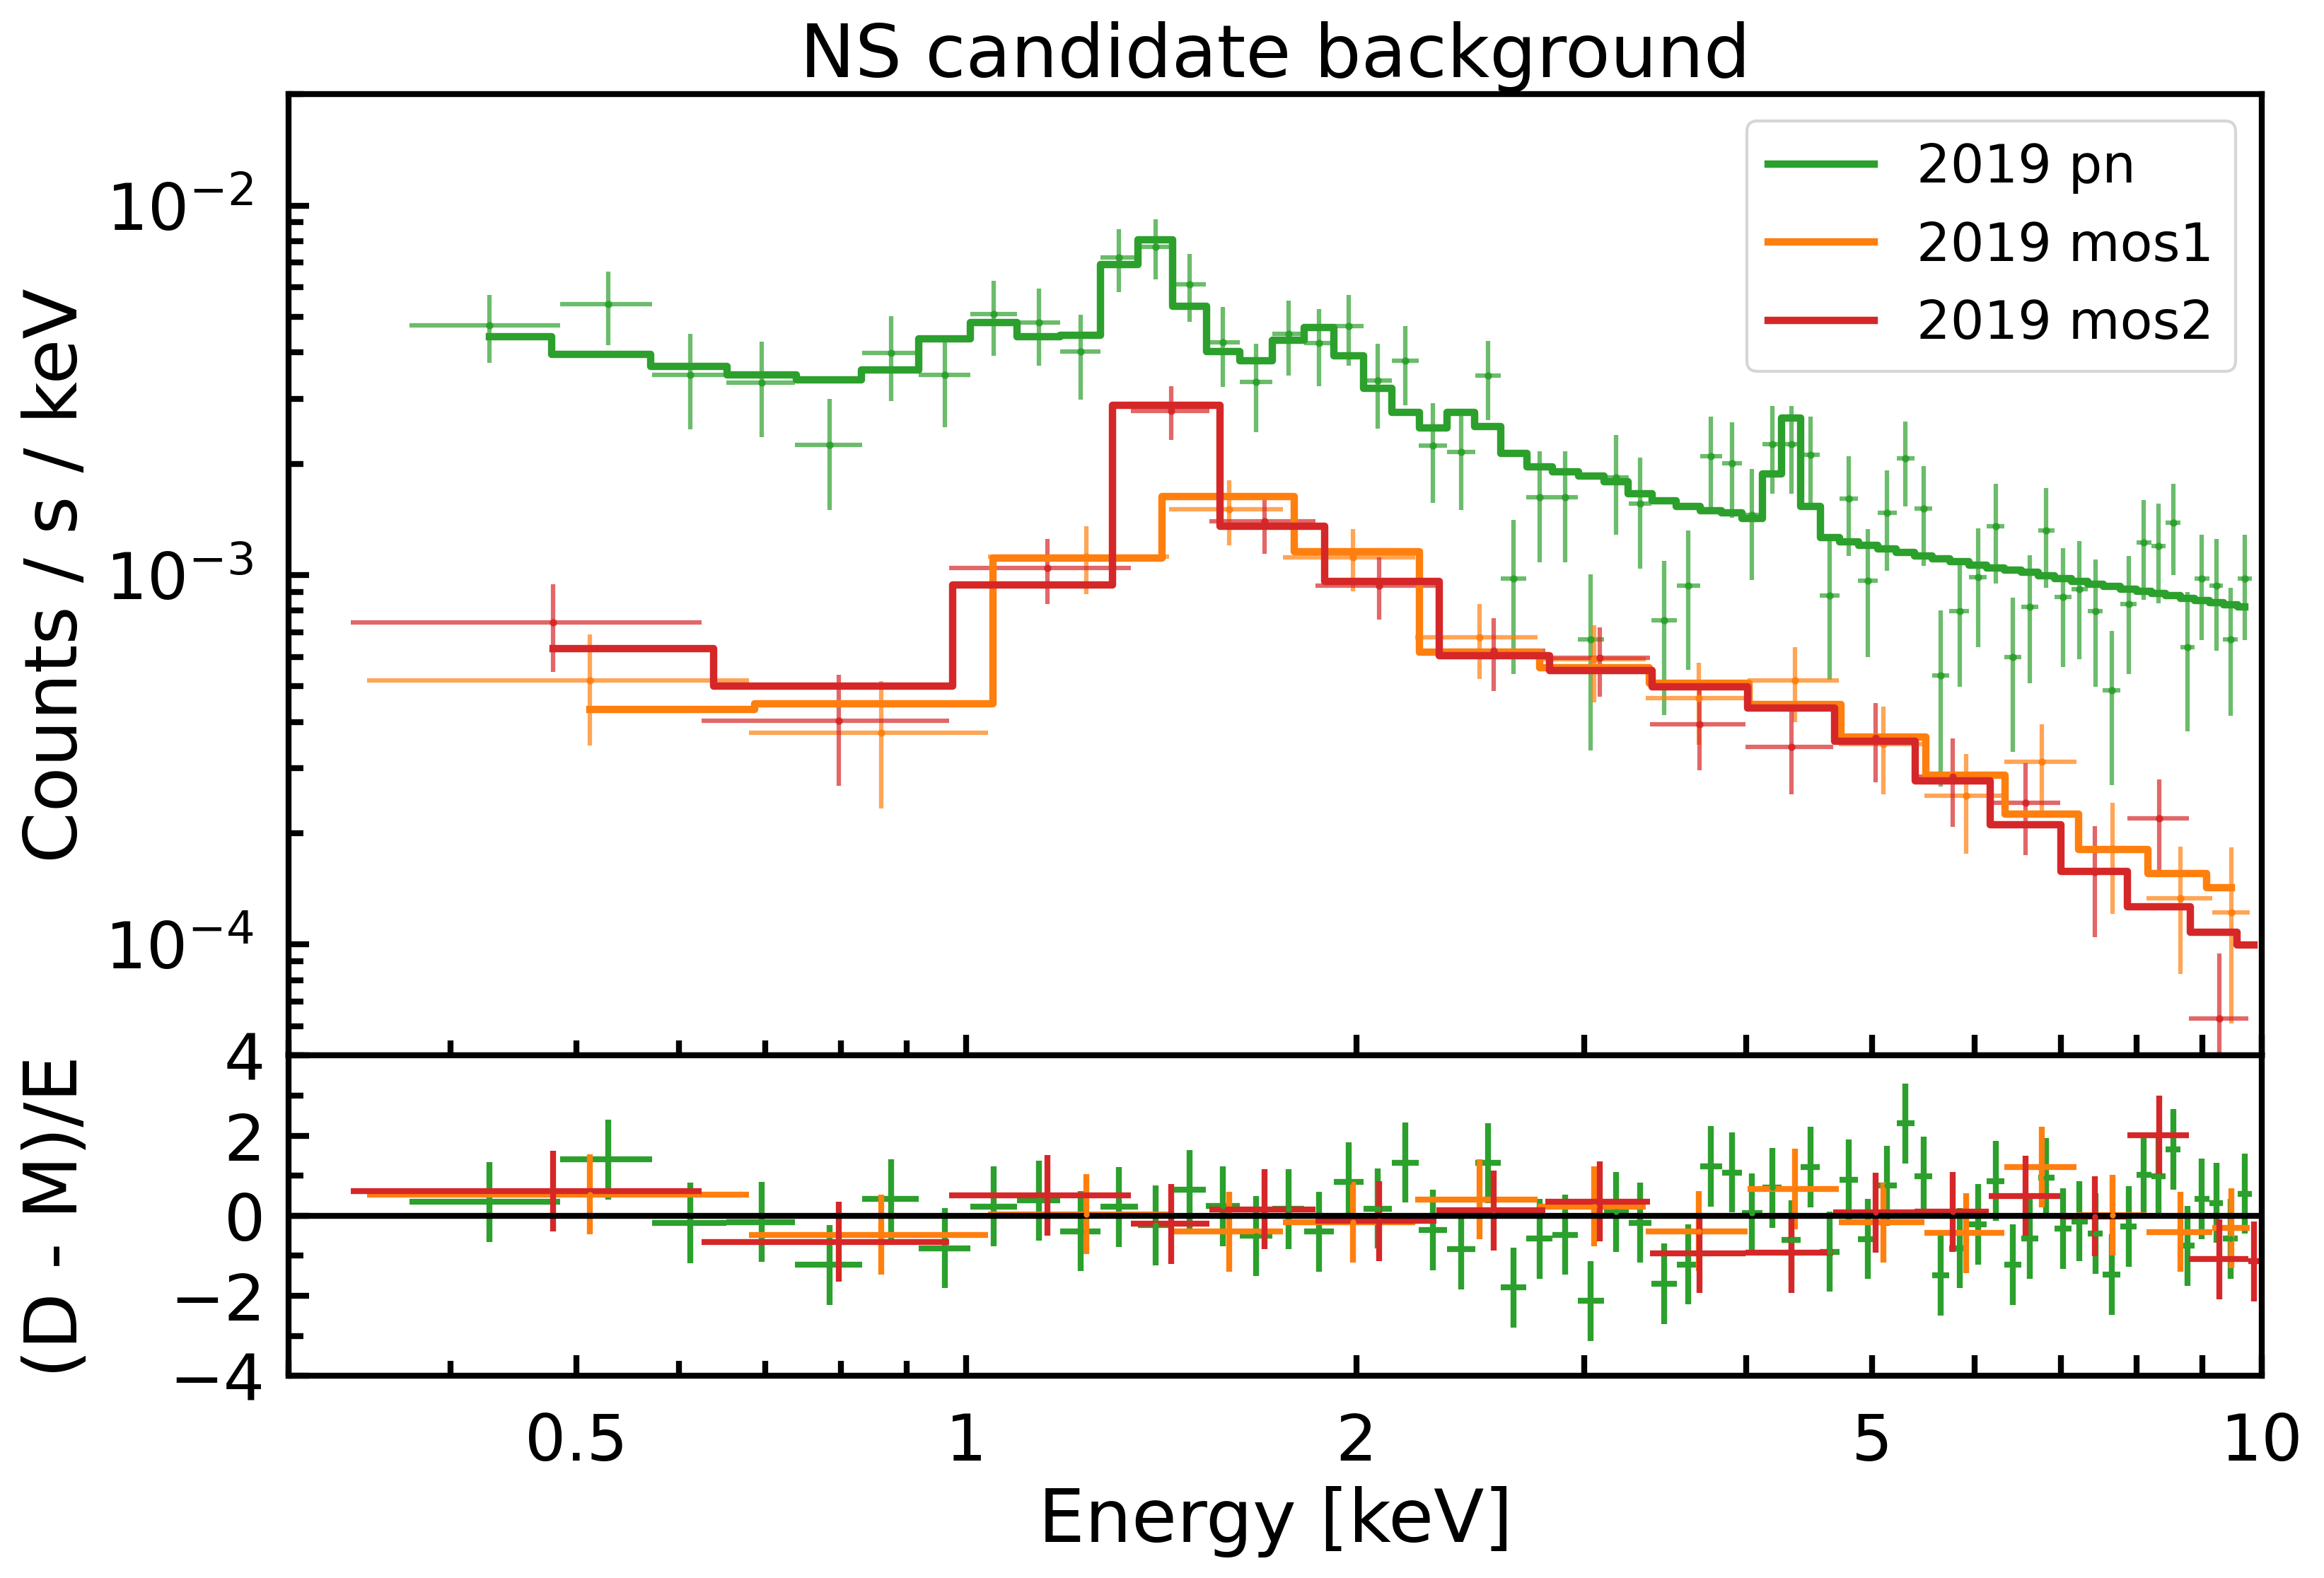

In [44]:
dat_19m1 = np.loadtxt('../data/analysis/background_ps/plt_bkghalfann_m12pn_04_09_c186_d182_spec_19m1.dat', skiprows=0, unpack=True)
dat_19m2 = np.loadtxt('../data/analysis/background_ps/plt_bkghalfann_m12pn_04_09_c186_d182_spec_19m2.dat', skiprows=0, unpack=True)
dat_19pn = np.loadtxt('../data/analysis/background_ps/plt_bkghalfann_m12pn_04_09_c186_d182_spec_19pn.dat', skiprows=0, unpack=True)

res_19m1 = np.loadtxt('../data/analysis/background_ps/plt_bkghalfann_m12pn_04_09_c186_d182_res_19m1.dat', skiprows=0, unpack=True)
res_19m2 = np.loadtxt('../data/analysis/background_ps/plt_bkghalfann_m12pn_04_09_c186_d182_res_19m2.dat', skiprows=0, unpack=True)
res_19pn = np.loadtxt('../data/analysis/background_ps/plt_bkghalfann_m12pn_04_09_c186_d182_res_19pn.dat', skiprows=0, unpack=True)

plt.clf()
plt.rcParams.update({'axes.titlesize': 'large',
                    'axes.linewidth': '2'})

fig = plt.figure(num=None, figsize=(12,8), dpi=300, facecolor='w', edgecolor='k')
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=4,rowspan=3)
plt.title('NS candidate background',fontsize=25)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.3,10)
ax1.set_ylim(5e-5,2e-2)

ax1.plot(dat_19pn[0],dat_19pn[2],'.',color="C2",ms=3,alpha=0.9)
ax1.errorbar(dat_19pn[0],dat_19pn[2],xerr=dat_19pn[1],yerr=dat_19pn[3],fmt="none",ecolor="C2",capsize=0,lod=True,lw=1.5,alpha=0.7)
ax1.step(dat_19pn[0],dat_19pn[4],'-',color="C2",ms=3,alpha=1,lw=2.5,where="mid",label="2019 pn") 

ax1.plot(dat_19m1[0],dat_19m1[2],'.',color="C1",ms=3,alpha=0.9)
ax1.errorbar(dat_19m1[0],dat_19m1[2],xerr=dat_19m1[1],yerr=dat_19m1[3],fmt="none",ecolor="C1",capsize=0,lod=True,lw=1.5,alpha=0.7)
ax1.step(dat_19m1[0],dat_19m1[4],'-',color="C1",ms=3,alpha=1,lw=2.5,where="mid",label="2019 mos1") 

ax1.plot(dat_19m2[0],dat_19m2[2],'.',color="C3",ms=3,alpha=0.9)
ax1.errorbar(dat_19m2[0],dat_19m2[2],xerr=dat_19m2[1],yerr=dat_19m2[3],fmt="none",ecolor="C3",capsize=0,lod=True,lw=1.5,alpha=0.7)
ax1.step(dat_19m2[0],dat_19m2[4],'-',color="C3",ms=3,alpha=1,lw=2.5,where="mid",label="2019 mos2") 

# bkg_19m1 = np.zeros_like(dat_19m1[0])
# bkg_19m2 = np.zeros_like(dat_19m2[0])

# for i in range(6,12):
# #     bkg_08m2 += dat_08m2[i]
#     bkg_19m1 += dat_19m1[i]
#     bkg_19m2 += dat_19m2[i]

# ax1.step(dat_08m2[0], bkg_08m2,'--',color="C0",lw=1.5,alpha=0.9, label="bkg")
# ax1.step(dat_19m1[0], bkg_19m1,'--',color="C1",lw=1.5,alpha=0.9, label="bkg")
# ax1.step(dat_19m2[0], bkg_19m2,'--',color="black",lw=2,alpha=0.9, label="2019 mos2 bkg")


ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_ticklabels([])

ax1.tick_params(axis="both", pad=12,labelsize=22,size=10, direction='in')
ax1.tick_params(which='minor', length=5,width=2,labelsize=16, direction='in')
ax1.tick_params(which='major', length=7,width=2, direction='in')


ax1.legend(prop={'size':18})
ax1.set_xlabel(r"Energy [keV]",fontsize=25)
ax1.set_ylabel("Counts / s / keV",fontsize=25)


ax2 = plt.subplot2grid((4, 4), (3, 0), colspan=4)
ax2.set_xscale('log')
ax2.set_yscale('linear')
ax2.set_xlim(0.3,10)
ax2.set_ylim(-4,4)
plt.subplots_adjust(hspace=0.)

ax2.xaxis.set_major_locator(MultipleLocator(1))
ax2.yaxis.set_major_locator(MultipleLocator(2))
ax2.yaxis.set_minor_locator(MultipleLocator(1))

tick_values = [0.5,1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
tick_labels = [0.5, 1, 2, "", "", 5, "", "", "", "", 10]
ax2.set_xticks(tick_values)
ax2.xaxis.set_ticklabels(tick_labels)


ax2.plot([0,10.0],[0,0],color="black",lw=2)

ax2.plot(res_19pn[0],res_19pn[2],'.',color="C2",ms=2)
ax2.errorbar(res_19pn[0],res_19pn[2],xerr=res_19pn[1],yerr=res_19pn[3],fmt="none",ecolor="C2",capsize=0,lod=True,lw=2)

ax2.plot(res_19m1[0],res_19m1[2],'.',color="C1",ms=2)
ax2.errorbar(res_19m1[0],res_19m1[2],xerr=res_19m1[1],yerr=res_19m1[3],fmt="none",ecolor="C1",capsize=0,lod=True,lw=2)

ax2.plot(res_19m2[0],res_19m2[2],'.',color="C3",ms=2)
ax2.errorbar(res_19m2[0],res_19m2[2],xerr=res_19m2[1],yerr=res_19m2[3],fmt="none",ecolor="C3",capsize=0,lod=True,lw=2)


ax2.set_xlabel(r'Energy [keV]',fontsize=25)
ax2.set_ylabel('(D - M)/E',fontsize=25, labelpad=26)

ax2.tick_params(axis="x", pad=12,labelsize=22,size=10, direction='in')
ax2.tick_params(axis="y", pad=8,labelsize=22, direction='in')
ax2.tick_params(axis='both', which='minor', length=5,width=2, direction='in')
ax2.tick_params(axis='both', which='major', length=7,width=2, direction='in')

plt.savefig('fig_spec_point_source_background.pdf', bbox_inches='tight')
plt.show()